# Exploratory Data Analysis: World Happiness Prediction (2015-2019)

### By Natalia López Gallego

-----------------------------------------------------------------------------



This notebook performs an exploratory data analysis (EDA) on world happiness datasets from 2015 to 2019. The data comes from the world happiness reports, which include variables such as GDP per capita, social support, life expectancy, freedom, generosity, and perception of corruption.

**Objectives**:
- Explore the distribution, correlations, and trends of the variables.
- Prepare the data to train a regression model that predicts the normalized `happiness_score` in the range [0, 10].

**Assumptions**:
- The datasets for different years have similar structures but inconsistent column names that will be standardized.
- Missing values will be handled through imputation or removal depending on their impact.

**Limitations**:
- Differences in columns between years may limit comparability.
- The amount of data per year is limited (~150-158 rows), which may affect the model's generalization.

#### Metadata
- **Author**: Natalia López Gallego
- **Python Version**: 3.12.10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry
from tabulate import tabulate
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code
from rapidfuzz import process
import scipy.stats as stats
from scipy.stats import  skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


## 1. Data Loading and Cleaning

In this section, we load the datasets from 2015 to 2019, standardize the column names, convert them to `snake_case` format, and select only the common columns to facilitate analysis and modeling.

In [2]:
data = [
    "../data/external/2015.csv",
    "../data/external/2016.csv",
    "../data/external/2017.csv",
    "../data/external/2018.csv",
    "../data/external/2019.csv"
]

dfs = {}  # Dictionary to save DataFrames by year

for file in data:
    # Extract year from filename correctly
    year = file.split("/")[-1][:4]  # "2015.csv" → "2015"
    df = pd.read_csv(file)
    dfs[year] = df  # Save the DataFrame with key = year

In [3]:
for year, df in dfs.items():
    print(f"\n{year} DataFrame:\n")
    df.info()


2015 DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(

In [4]:
# Diccionario of standar names by year
column_renames = {
    "2015": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Standard Error": "Standard Error",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2016": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Lower Confidence Interval": "CI Lower",
        "Upper Confidence Interval": "CI Upper",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2017": {
        "Country": "Country",
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Whisker.high": "CI Upper",
        "Whisker.low": "CI Lower",
        "Economy..GDP.per.Capita.": "Economy",
        "Family": "Family",
        "Health..Life.Expectancy.": "Health",
        "Freedom": "Freedom",
        "Trust..Government.Corruption.": "Trust",
        "Generosity": "Generosity",
        "Dystopia.Residual": "Dystopia Residual"
    },
    "2018": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    },
    "2019": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    }
}

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    if year in column_renames:
        dfs[year] = df.rename(columns=column_renames[year])


In [5]:
def to_snake_case(column_name):
    column_name = column_name.lower() 
    column_name = re.sub(r'\s+', '_', column_name) 
    column_name = re.sub(r'[^\w\s]', '', column_name)  
    return column_name

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    # Renaming each column to snake_case
    df.columns = [to_snake_case(col) for col in df.columns]

In [6]:
# Obtener las columnas comunes entre todos los DataFrames
common_columns = set(dfs['2015'].columns)  # Iniciar con las columnas del primer DataFrame

# Iterar por los DataFrames y actualizar las columnas comunes
for year, df in dfs.items():
    common_columns &= set(df.columns)  # Intersección de columnas

# Convertir las columnas comunes a lista
common_columns = list(common_columns)

# Filtrar los DataFrames para que solo contengan las columnas comunes
for year, df in dfs.items():
    dfs[year] = df[common_columns]  # Filtra solo las columnas comunes

# Verificar el resultado
for year, df in dfs.items():
    print(f"DataFrame for {year} with common columns:\n", df.columns)

DataFrame for 2015 with common columns:
 Index(['generosity', 'economy', 'family', 'happiness_score', 'country',
       'health', 'trust', 'happiness_rank', 'freedom'],
      dtype='object')
DataFrame for 2016 with common columns:
 Index(['generosity', 'economy', 'family', 'happiness_score', 'country',
       'health', 'trust', 'happiness_rank', 'freedom'],
      dtype='object')
DataFrame for 2017 with common columns:
 Index(['generosity', 'economy', 'family', 'happiness_score', 'country',
       'health', 'trust', 'happiness_rank', 'freedom'],
      dtype='object')
DataFrame for 2018 with common columns:
 Index(['generosity', 'economy', 'family', 'happiness_score', 'country',
       'health', 'trust', 'happiness_rank', 'freedom'],
      dtype='object')
DataFrame for 2019 with common columns:
 Index(['generosity', 'economy', 'family', 'happiness_score', 'country',
       'health', 'trust', 'happiness_rank', 'freedom'],
      dtype='object')


In [7]:
def standardize_country(country_name):
    """
    Standardizes country names using fuzzy matching with pycountry.

    Finds the closest match in pycountry based on fuzzy similarity and corrects discrepancies.

    Parameters:
    country_name (str): Name of the country from the dataset.

    Returns:
    str: The corrected country name or 'Unknown' if no match is found.
    """
    if pd.isna(country_name) or not isinstance(country_name, str):  # Handle missing/null values
        return "Unknown"

    country_name = country_name.strip()  # Remove extra spaces
    country_list = [country.name for country in pycountry.countries]  # Get official country names

    match_result = process.extractOne(country_name, country_list)  # Fuzzy match

    if match_result:  
        best_match, score = match_result[:2]  # Extract only first two values
        return best_match if score > 80 else "Unknown"
    
    return "Unknown"  # Default fallback if no match found

In [8]:
for year, df in dfs.items():
    if "country" in df.columns:
        df["Standardized Country"] = df["country"].apply(standardize_country)  # Standardize names


In [9]:
# Collect unique country names from all DataFrames in dfs
unique_countries = set()  # Use a set to avoid duplicates

for year, df in dfs.items():
    if "Standardized Country" in df.columns:
        unique_countries.update(df["Standardized Country"].unique())  # Add unique values

# Print sorted list of unique countries
print(sorted(unique_countries))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia, Plurinational State of', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Mala

In [10]:
def get_continent(country_name):
    """
    Returns the continent for a given standardized country name.

    Uses pycountry-convert to map country names to ISO Alpha-2 codes, then to continent codes.

    Parameters:
    country_name (str): Standardized country name.

    Returns:
    str: The continent the country belongs to, or 'Unknown' if not found.
    """
    if pd.isna(country_name) or not isinstance(country_name, str):  # Handle missing/null values
        return "Unknown"

    country_name = country_name.strip()  # Remove extra spaces

    try:
        # Convert country name to Alpha-2 code
        country_code = country_name_to_country_alpha2(country_name)

        # Convert Alpha-2 code to continent
        continent_code = country_alpha2_to_continent_code(country_code)

        # Continent mapping dictionary
        continent_mapping = {
            "NA": "North America",
            "SA": "South America",
            "EU": "Europe",
            "AF": "Africa",
            "AS": "Asia",
            "OC": "Oceania"
        }

        return continent_mapping.get(continent_code, "Unknown")

    except (KeyError, LookupError):
        return "Unknown"  # Handle cases where mapping fails

In [11]:
for year, df in dfs.items():
    if "Standardized Country" in df.columns:
        df["Continent"] = df["Standardized Country"].apply(get_continent)

In [12]:
# Collect unique continent values from all DataFrames
unique_continents = set()

for year, df in dfs.items():
    if "Continent" in df.columns:
        unique_continents.update(df["Continent"].unique())  # Add unique values

# Print sorted list of unique continents
print(sorted(unique_continents))

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America', 'Unknown']


In [13]:
for year, df in dfs.items():
    if "Continent" in df.columns:
        df.rename(columns={"Continent": "continent"}, inplace=True)

In [14]:
for year, df in dfs.items():
    print(f"Columns in {year}:")
    print(df.columns.tolist())  # Converts column index to list for easy reading
    print("-" * 40)  # Adds a separator for better readability

Columns in 2015:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2016:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2017:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2018:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2019:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'Standardized Country', 'continen

In [15]:
for year, df in dfs.items():
    columns_to_drop = ["Standardized Country"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

In [16]:
for year, df in dfs.items():
    if "Standardized Country" in df.columns:
        df.rename(columns={"Standardized Country": "country"}, inplace=True)

In [17]:
for year, df in dfs.items():
    print(f"Columns in {year}:")
    print(df.columns.tolist())  # Converts column index to list for easy reading
    print("-" * 40)  # Adds a separator for better readability

Columns in 2015:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'continent']
----------------------------------------
Columns in 2016:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'continent']
----------------------------------------
Columns in 2017:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'continent']
----------------------------------------
Columns in 2018:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'continent']
----------------------------------------
Columns in 2019:
['generosity', 'economy', 'family', 'happiness_score', 'country', 'health', 'trust', 'happiness_rank', 'freedom', 'continent']
----------------------------------------


## 2. Exploratory Data Analysis

We explore the structure of the data, check for missing values, analyze distributions, correlations, outliers, and temporal trends to better understand the variables and their relationship with `happiness_score`.

In [18]:
for year, df in dfs.items():
    print(f"DataFrame for {year} - Number of rows and columns:\n", df.shape)

DataFrame for 2015 - Number of rows and columns:
 (158, 10)
DataFrame for 2016 - Number of rows and columns:
 (157, 10)
DataFrame for 2017 - Number of rows and columns:
 (155, 10)
DataFrame for 2018 - Number of rows and columns:
 (156, 10)
DataFrame for 2019 - Number of rows and columns:
 (156, 10)


In [19]:
for year, df in dfs.items():
    print(f"Describe for {year}:\n", df.describe(), "\n")

Describe for 2015:
        generosity     economy      family  happiness_score      health  \
count  158.000000  158.000000  158.000000       158.000000  158.000000   
mean     0.237296    0.846137    0.991046         5.375734    0.630259   
std      0.126685    0.403121    0.272369         1.145010    0.247078   
min      0.000000    0.000000    0.000000         2.839000    0.000000   
25%      0.150553    0.545808    0.856823         4.526000    0.439185   
50%      0.216130    0.910245    1.029510         5.232500    0.696705   
75%      0.309883    1.158448    1.214405         6.243750    0.811013   
max      0.795880    1.690420    1.402230         7.587000    1.025250   

            trust  happiness_rank     freedom  
count  158.000000      158.000000  158.000000  
mean     0.143422       79.493671    0.428615  
std      0.120034       45.754363    0.150693  
min      0.000000        1.000000    0.000000  
25%      0.061675       40.250000    0.328330  
50%      0.107220       7

In [20]:
# Función para detectar outliers usando IQR
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calcular los cuartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detectar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index.tolist()

    return outliers

# Iterar sobre los DataFrames para detectar outliers
for year, df in dfs.items():
    outliers = detect_outliers(df)
    print(f"Detected Outliers for {year}:\n", outliers, "\n")


Detected Outliers for 2015:
 {'generosity': [33, 128], 'economy': [], 'family': [147, 152, 157], 'happiness_score': [], 'health': [], 'trust': [0, 2, 3, 5, 7, 8, 16, 19, 23, 27, 71, 90, 129, 153], 'happiness_rank': [], 'freedom': []} 

Detected Outliers for 2016:
 {'generosity': [29, 32, 78, 118], 'economy': [], 'family': [154], 'happiness_score': [], 'health': [], 'trust': [0, 1, 3, 4, 7, 9, 19, 21, 27, 35, 96, 151], 'happiness_rank': [], 'freedom': []} 

Detected Outliers for 2017:
 {'generosity': [80, 113], 'economy': [], 'family': [142, 149, 151, 154], 'happiness_score': [], 'health': [], 'trust': [0, 1, 3, 4, 7, 8, 9, 14, 17, 20, 25, 34, 150], 'happiness_rank': [], 'freedom': []} 

Detected Outliers for 2018:
 {'generosity': [95, 129], 'economy': [19], 'family': [135, 149, 154], 'happiness_score': [], 'health': [], 'trust': [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 16, 18, 33, 75, 97, 150], 'happiness_rank': [], 'freedom': [136, 141]} 

Detected Outliers for 2019:
 {'generosity': [91, 1

In [21]:
# Iterar sobre los DataFrames y detectar valores nulos
for year, df in dfs.items():
    print(f"Null values for {year}:\n")

    # Mostrar los valores nulos por columna
    null_counts = df.isnull().sum()

    # Imprimir solo las columnas con valores nulos
    print(null_counts[null_counts > 0], "\n")

Null values for 2015:

Series([], dtype: int64) 

Null values for 2016:

Series([], dtype: int64) 

Null values for 2017:

Series([], dtype: int64) 

Null values for 2018:

trust    1
dtype: int64 

Null values for 2019:

Series([], dtype: int64) 



## Exploring Distributions

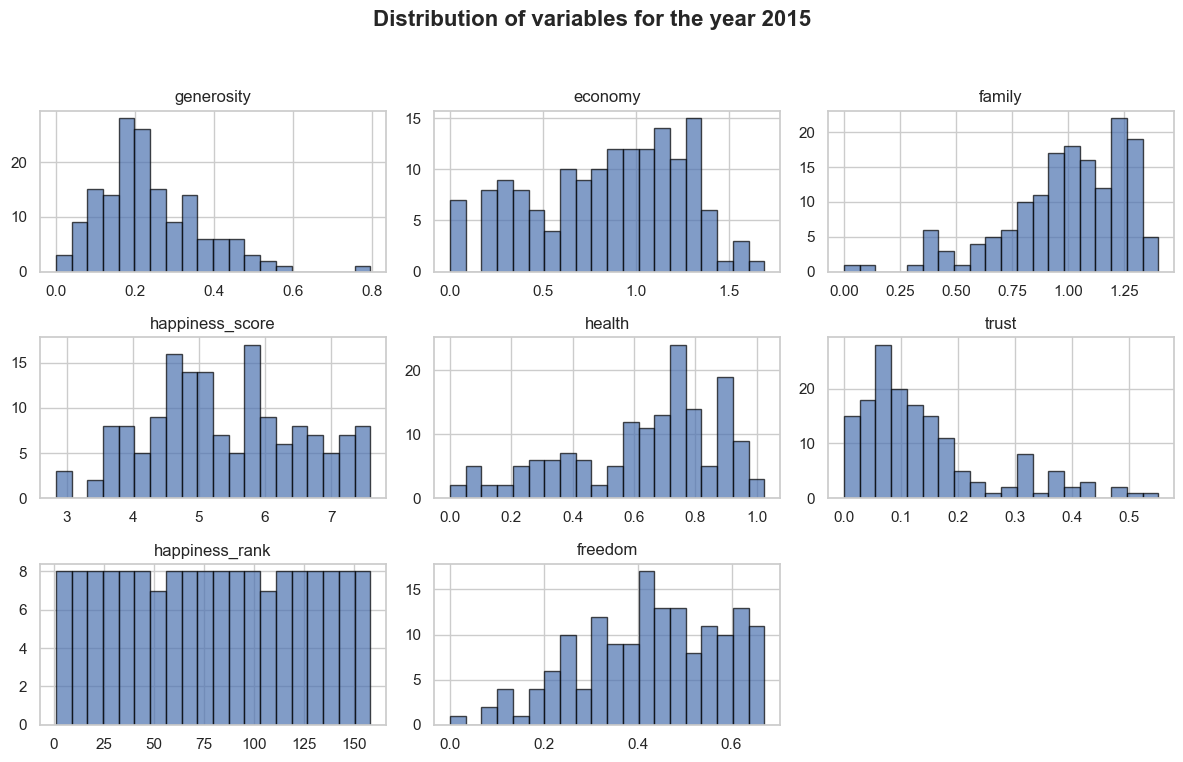

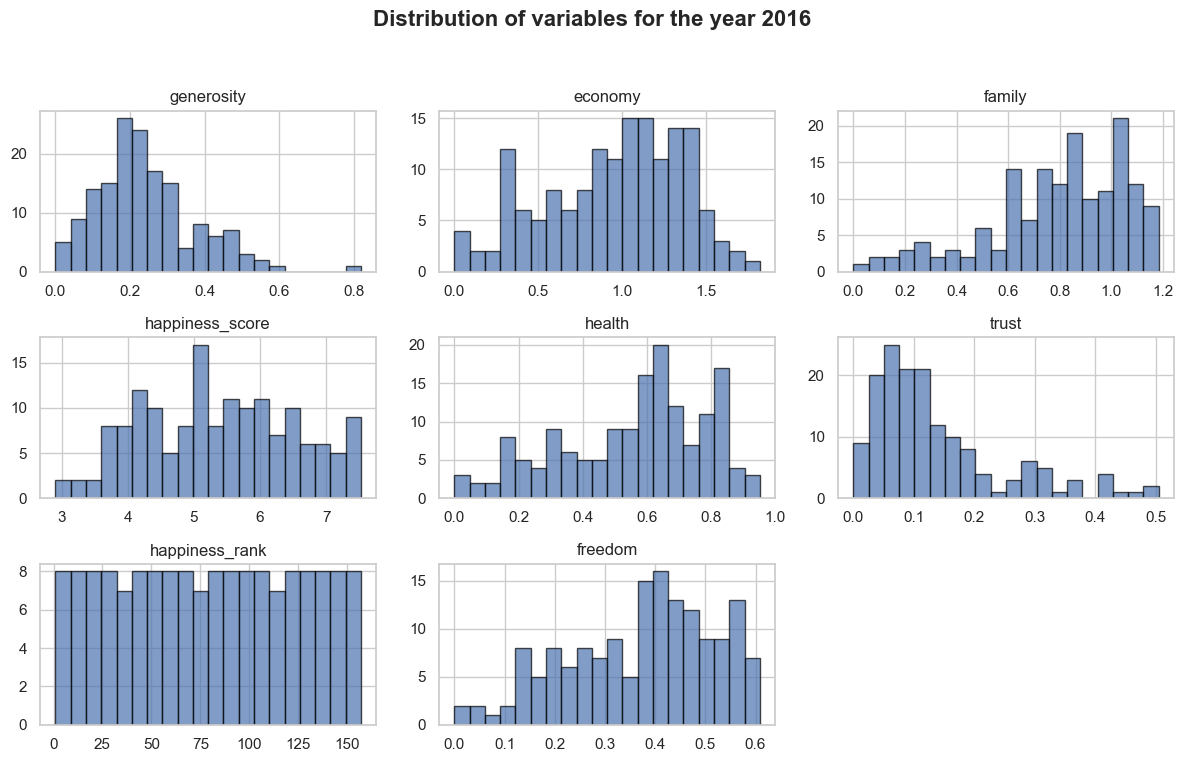

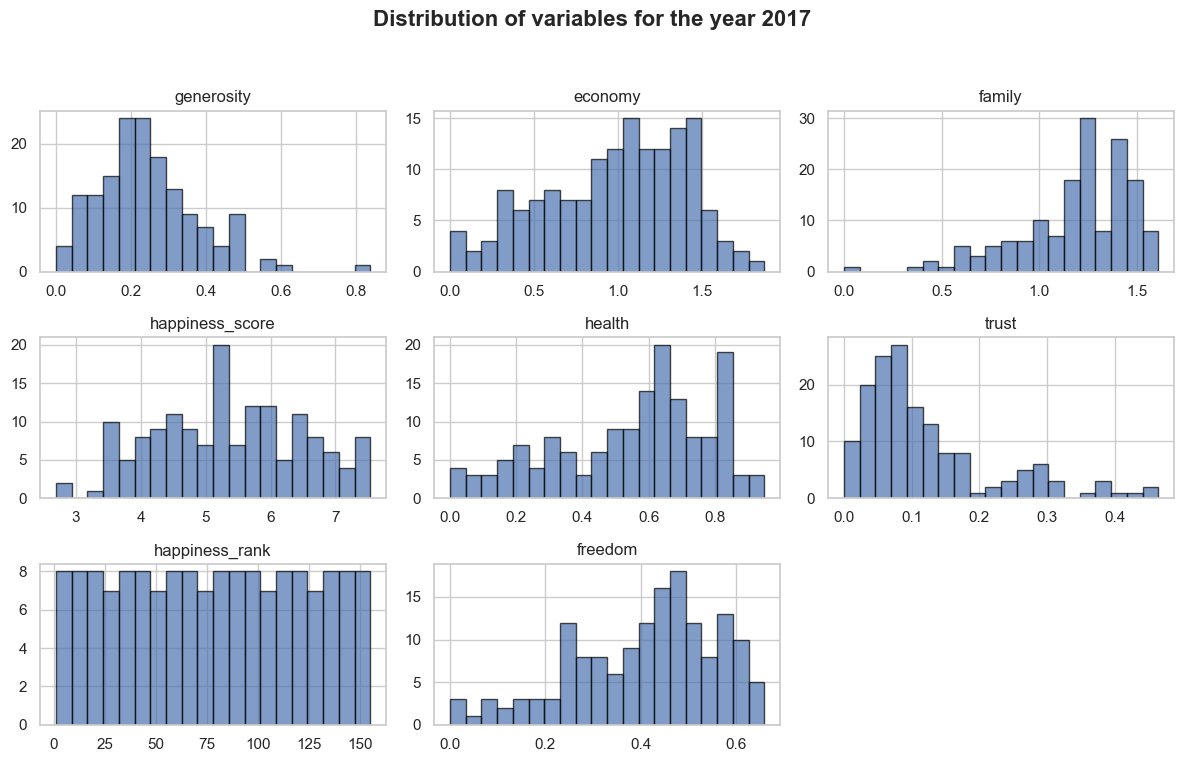

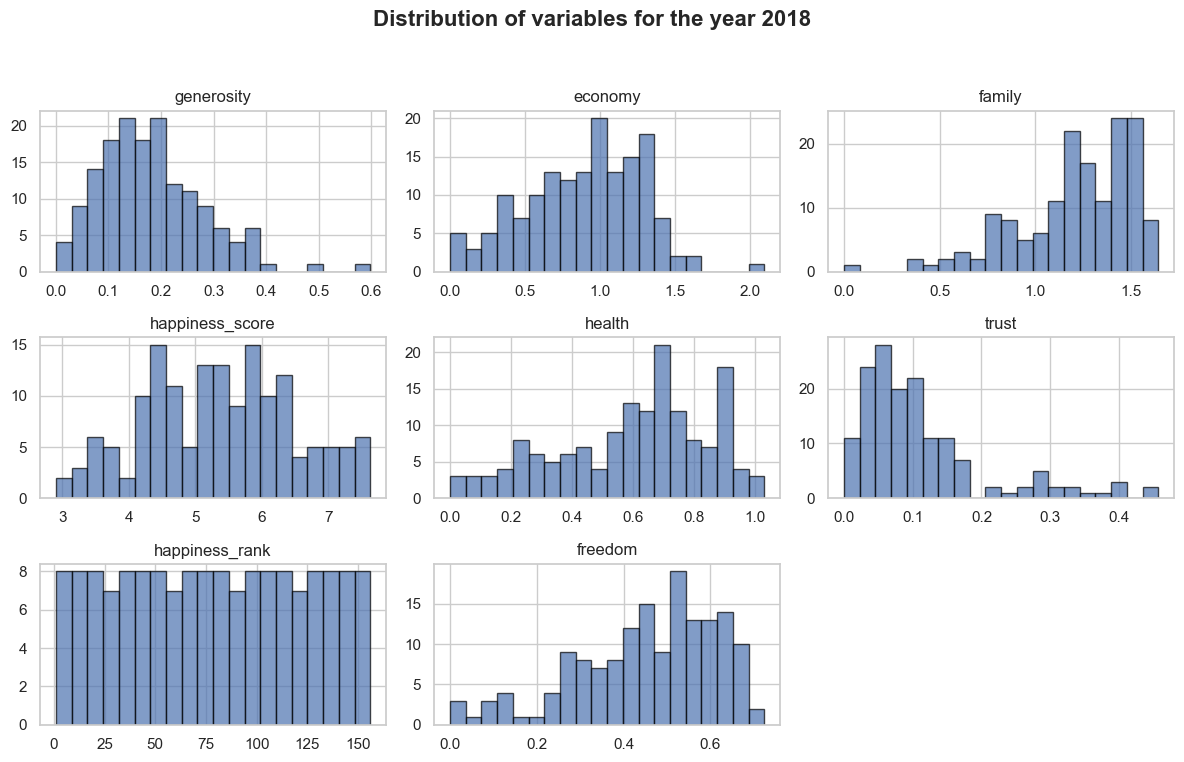

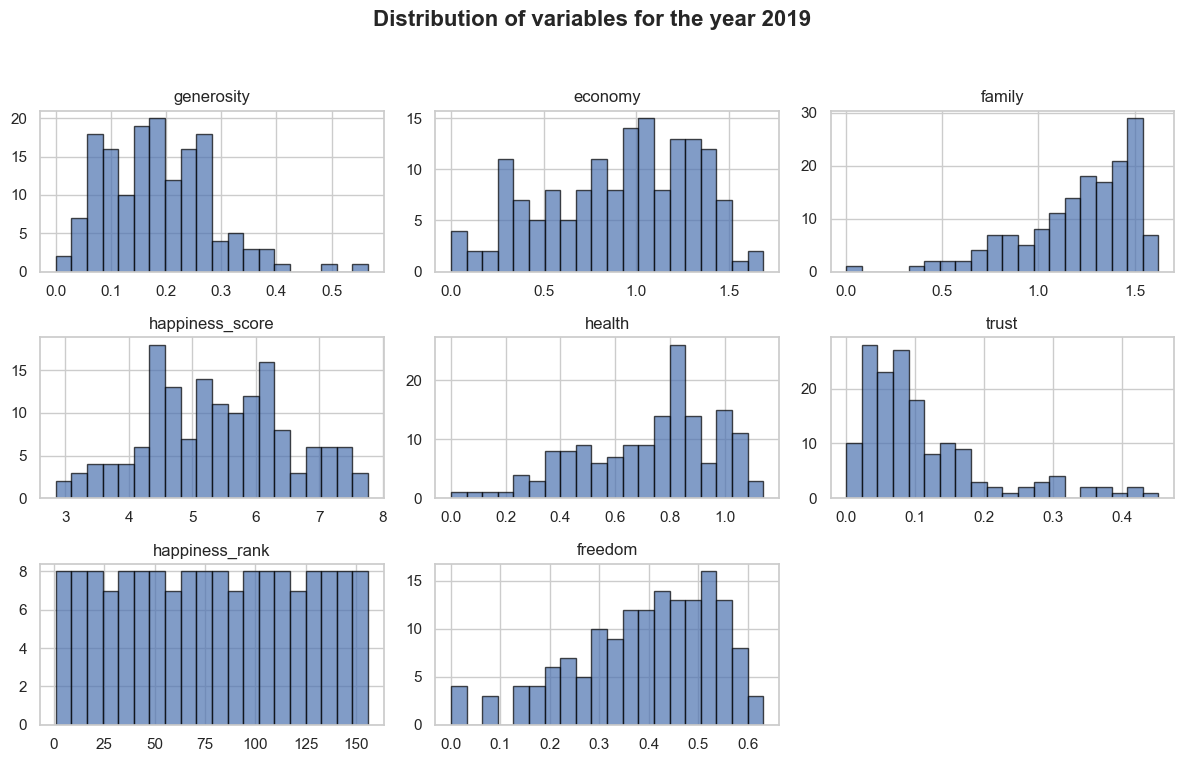

In [22]:
# Configuración estética de los gráficos
sns.set(style="whitegrid")  # Estilo de fondo blanco con líneas de cuadrícula
plt.rcParams["figure.figsize"] = (12, 8)  # Tamaño por defecto de las figuras

# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Generar el histograma de todas las columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Crear un histograma para cada columna numérica
    df_numeric.hist(bins=20, edgecolor='black', alpha=0.7)

    # Título y etiquetas
    plt.suptitle(f"Distribution of variables for the year {year}", fontsize=16, fontweight='bold')
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Ajustar el layout para que todo encaje bien
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Mostrar el gráfico
    plt.show()


### **Handling Null Values**

Como la distribución de `trust` para 2028 está sesgada a la derecha (right-skewed), la mediana es una opción más robusta que la media para imputar valores nulos. En este caso hay un solo valor nulo, y se manejará imputando la mediana.


In [23]:
#Calcular la mediana de 'trust' para 2018
median_trust_2018 = dfs['2018']['trust'].median()

# Imputar valores nulos con la mediana
dfs['2018']['trust'].fillna(median_trust_2018, inplace=True)

# Verificar que ya no hay valores nulos
print(dfs['2018']['trust'].isnull().sum())

0


### **Handling Outliers**

We're replacing outliers with the **median** because these values likely represent **extreme values*   that could distort the accuracy of predictive models. Here’s why this approach makes sense:

- **Median is robust to extreme values** → Unlike the mean, the median **does not shift due to outliers**.
- **Preserves the central tendency** → Instead of deleting data, replacing outliers with the median keeps the distribution balanced.
- As seen in the distributions graphs,the distributions are mostly skewed so it is better to input the median.

In [24]:
def impute_outliers_with_median(df):
    """
    Detects and imputes outliers by replacing them with the column median.

    - Uses the IQR method to identify outliers.
    - Replaces outliers with the median of the respective column.

    Parameters:
    df (pd.DataFrame): DataFrame to process.

    Returns:
    pd.DataFrame: DataFrame with outliers replaced.
    """
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate quartiles and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Compute median
        column_median = df[column].median()

        # Replace outliers with median
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), column_median, df[column])

    return df

In [25]:
for year, df in dfs.items():
    dfs[year] = impute_outliers_with_median(df)

## Exploration through graphs

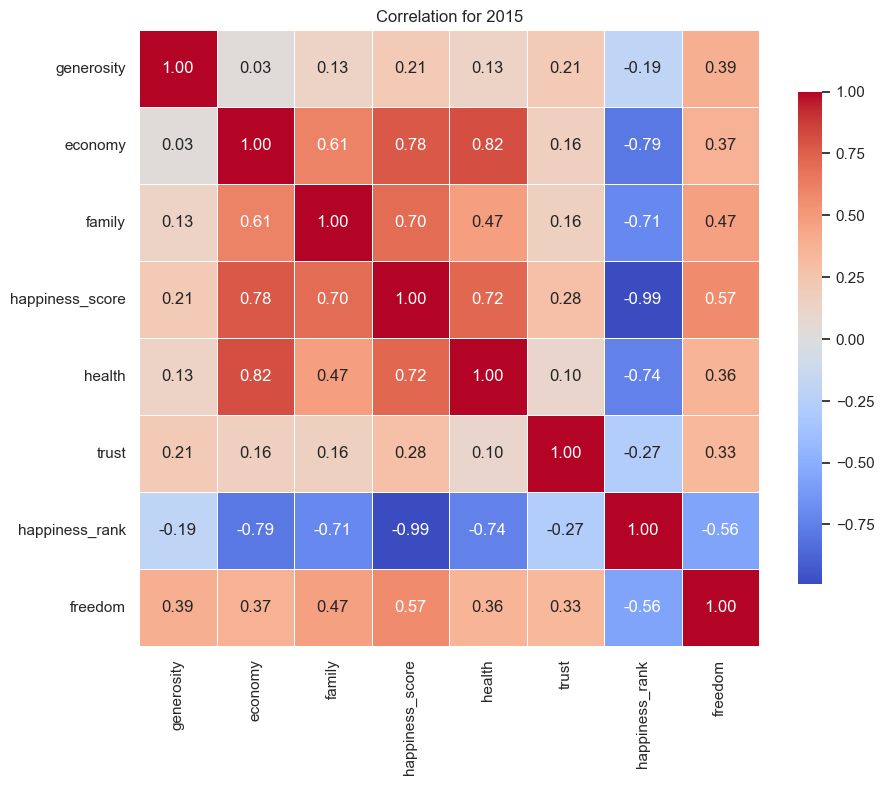

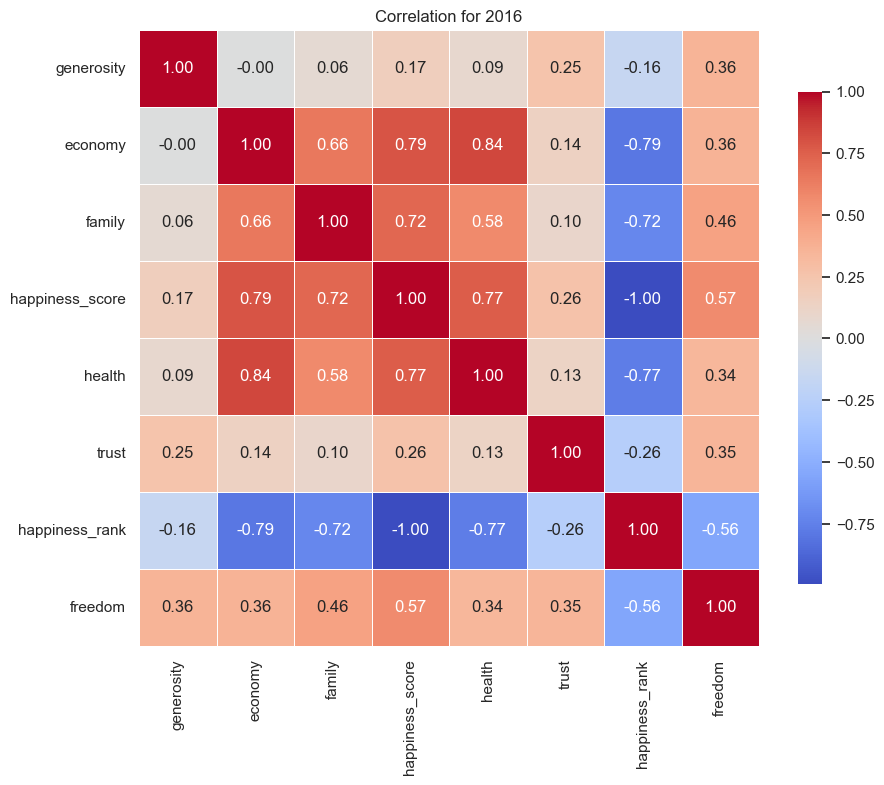

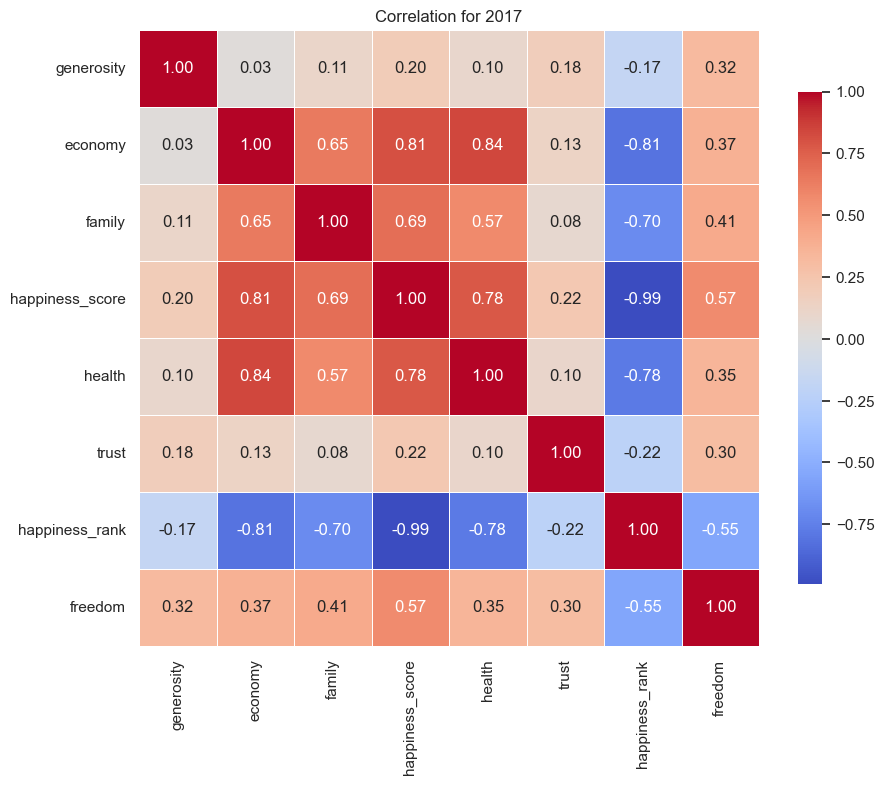

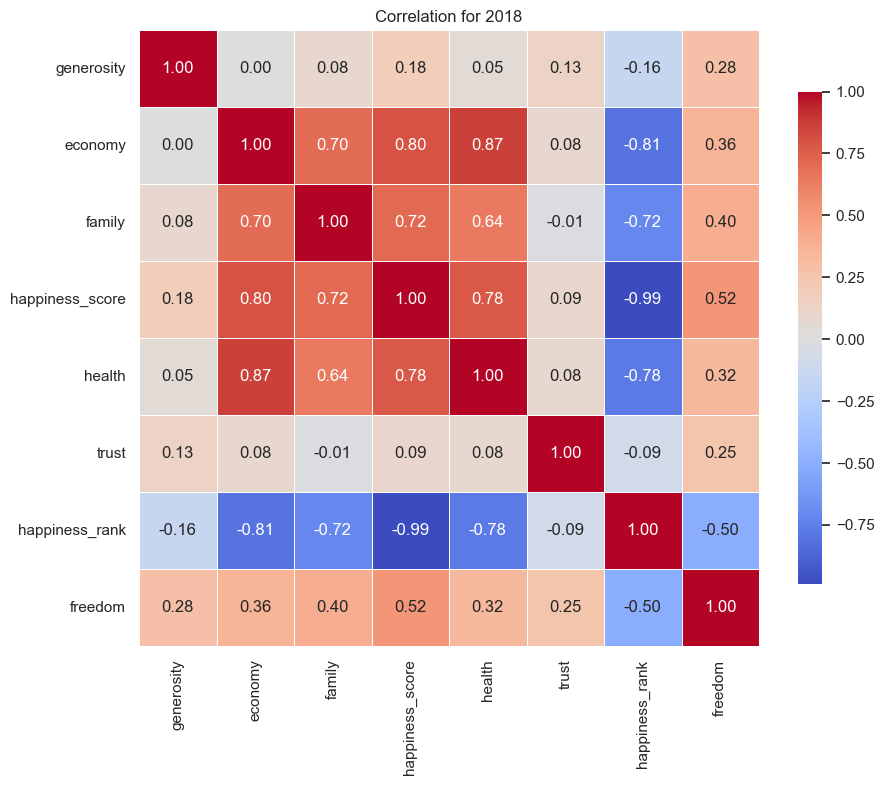

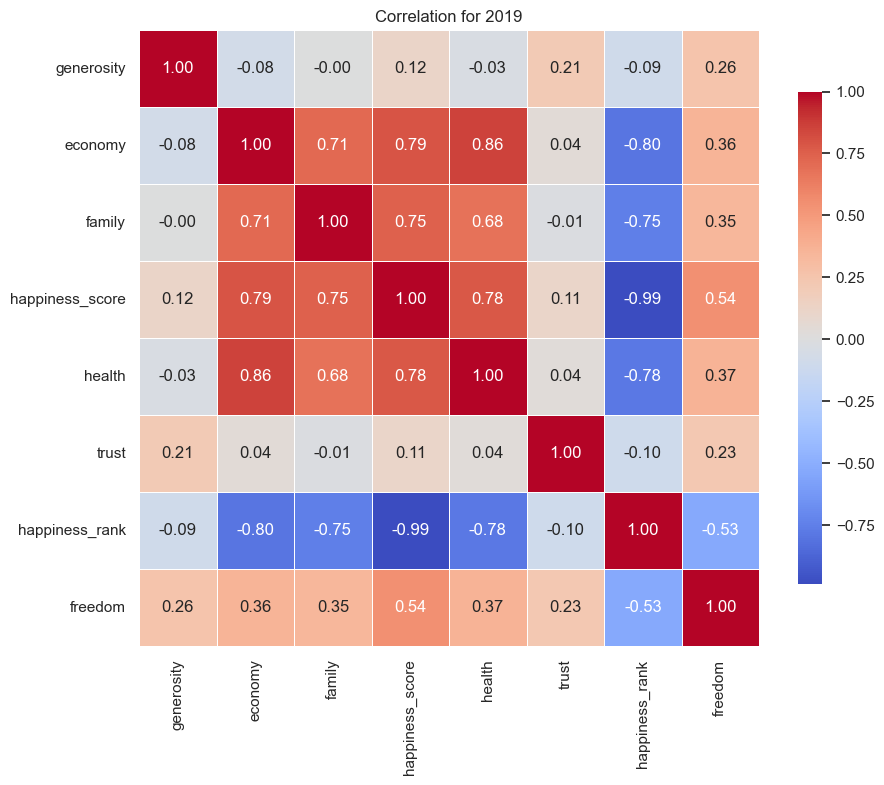

In [26]:
# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Seleccionar solo las columnas numéricas (sin necesidad de eliminar la columna 'Country')
    df_numeric = df.select_dtypes(include=['number'])

    # Calcular la matriz de correlación para las columnas numéricas
    corr = df_numeric.corr()

    # Crear un mapa de calor para la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    # Título del gráfico
    plt.title(f"Correlation for {year}")
    plt.show()

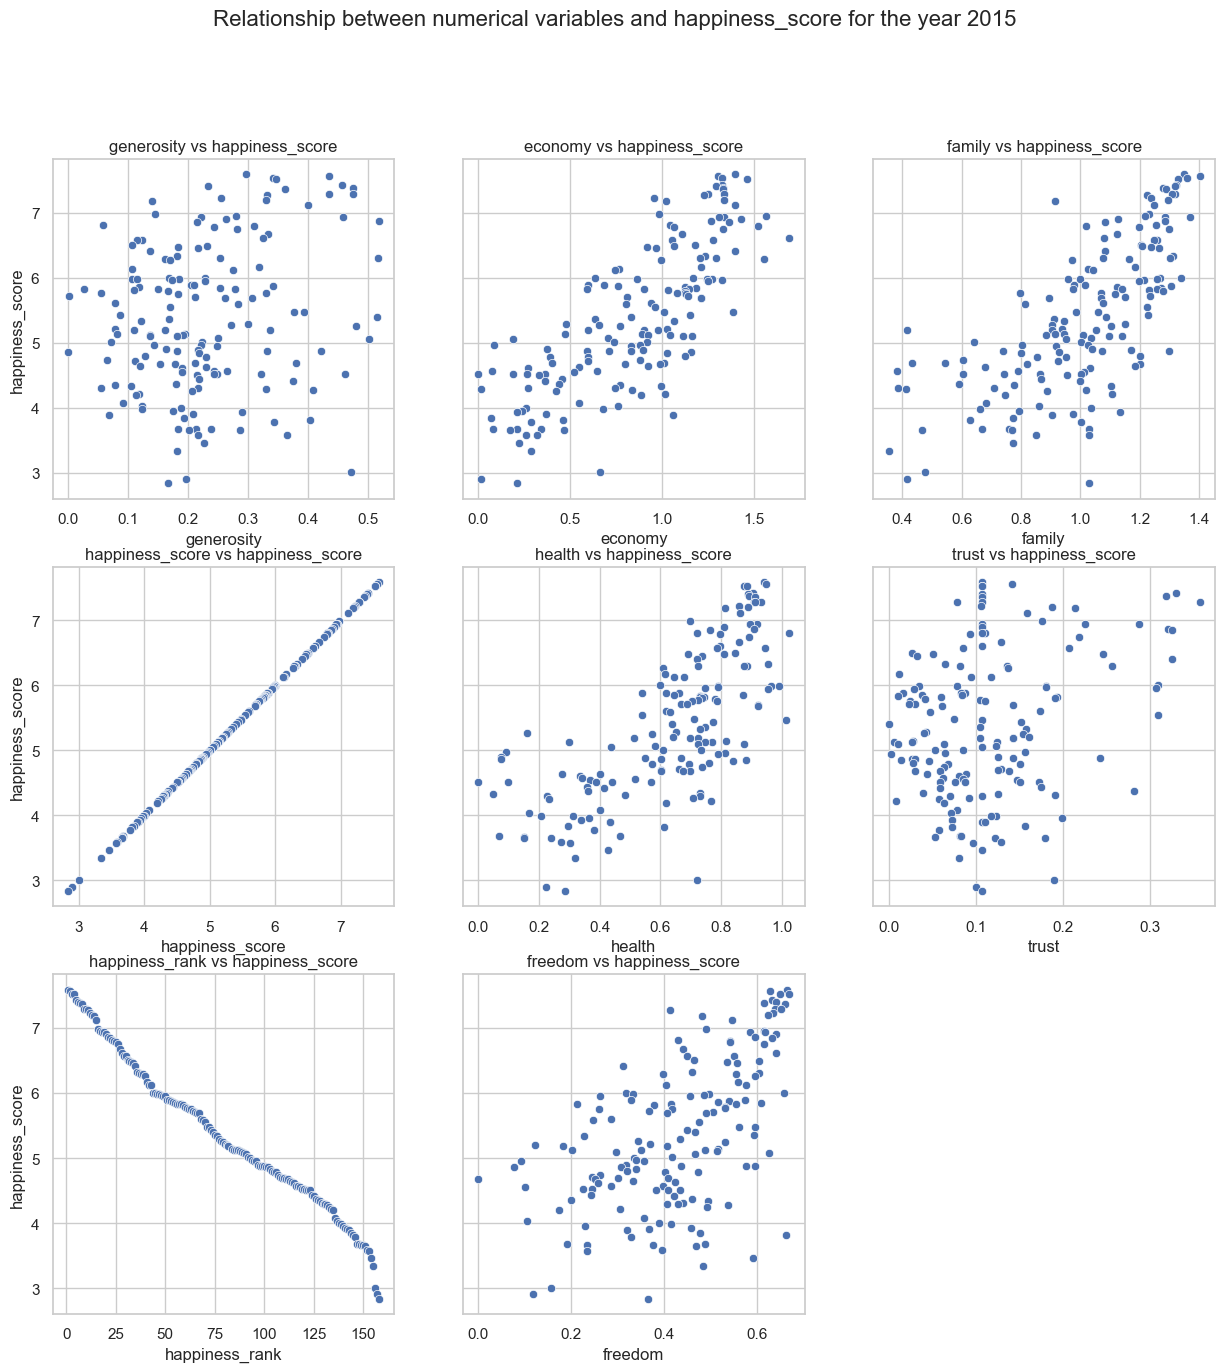

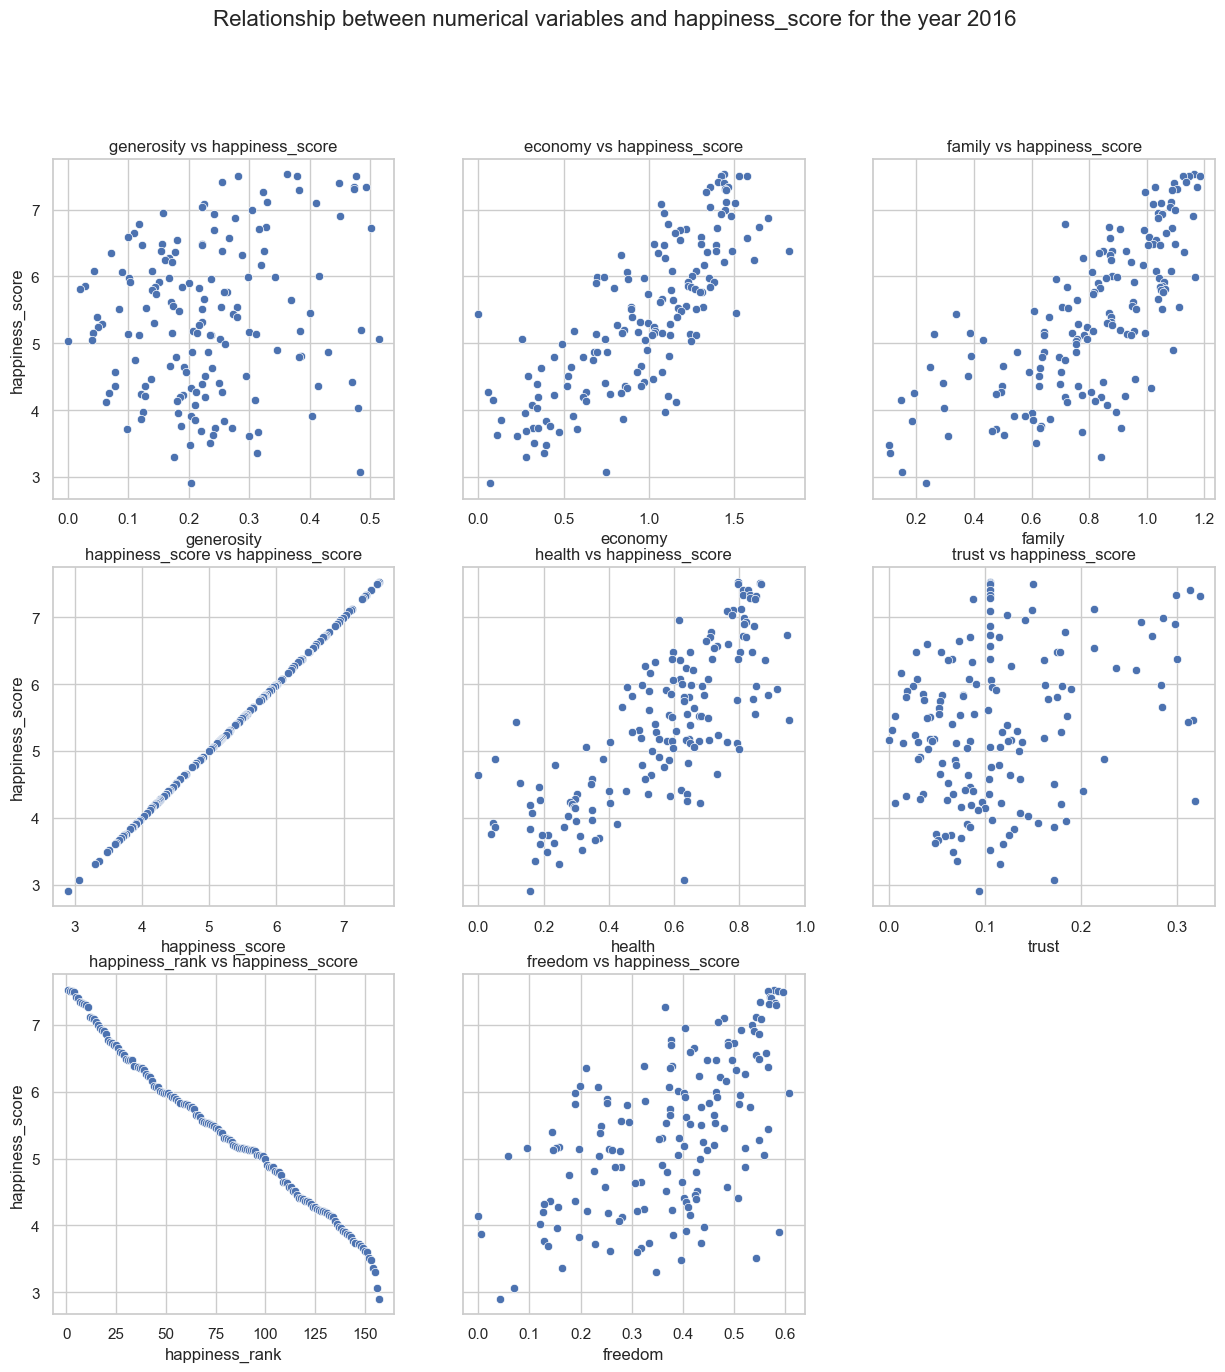

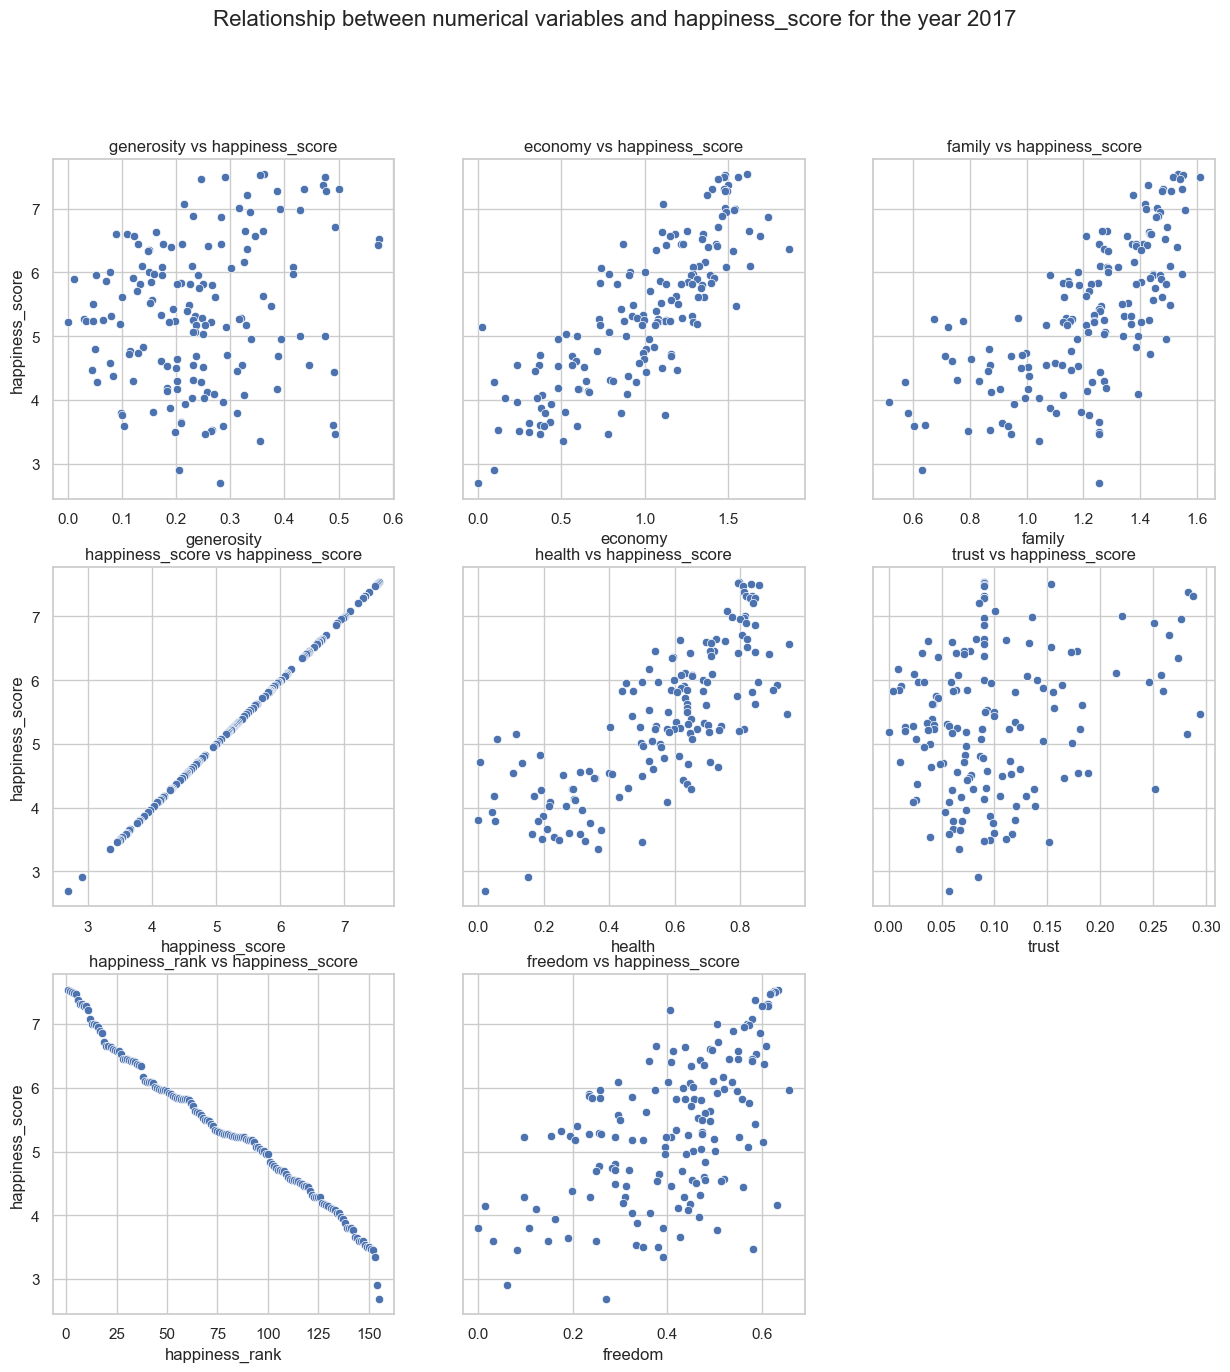

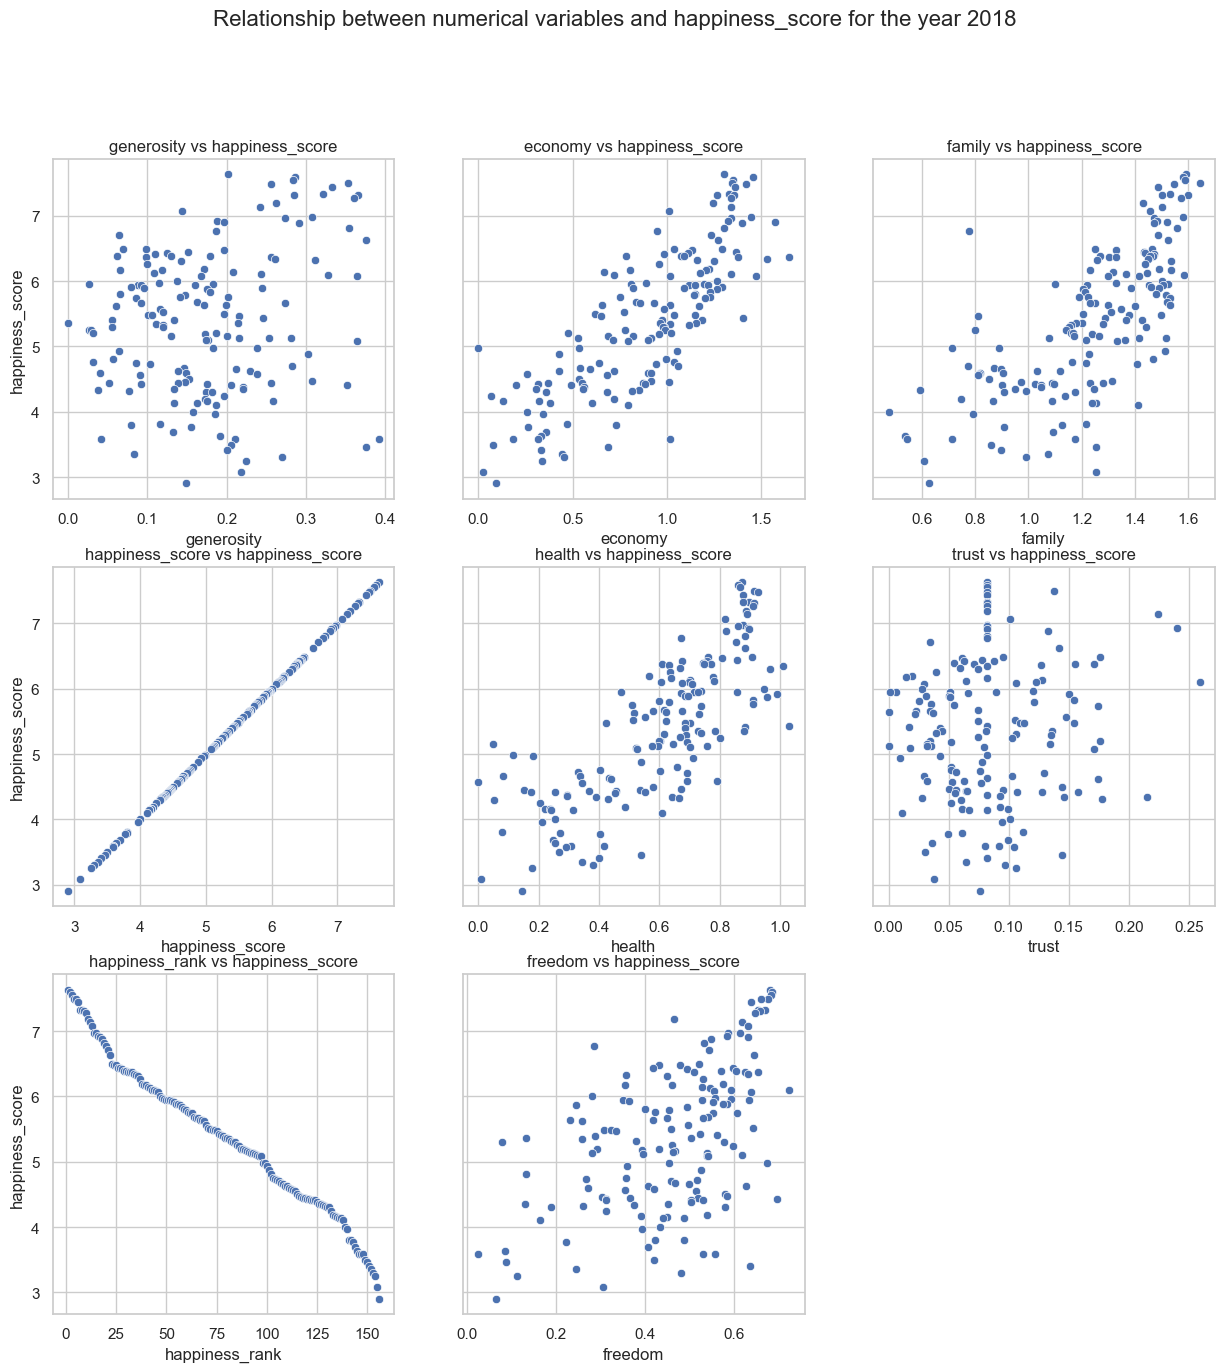

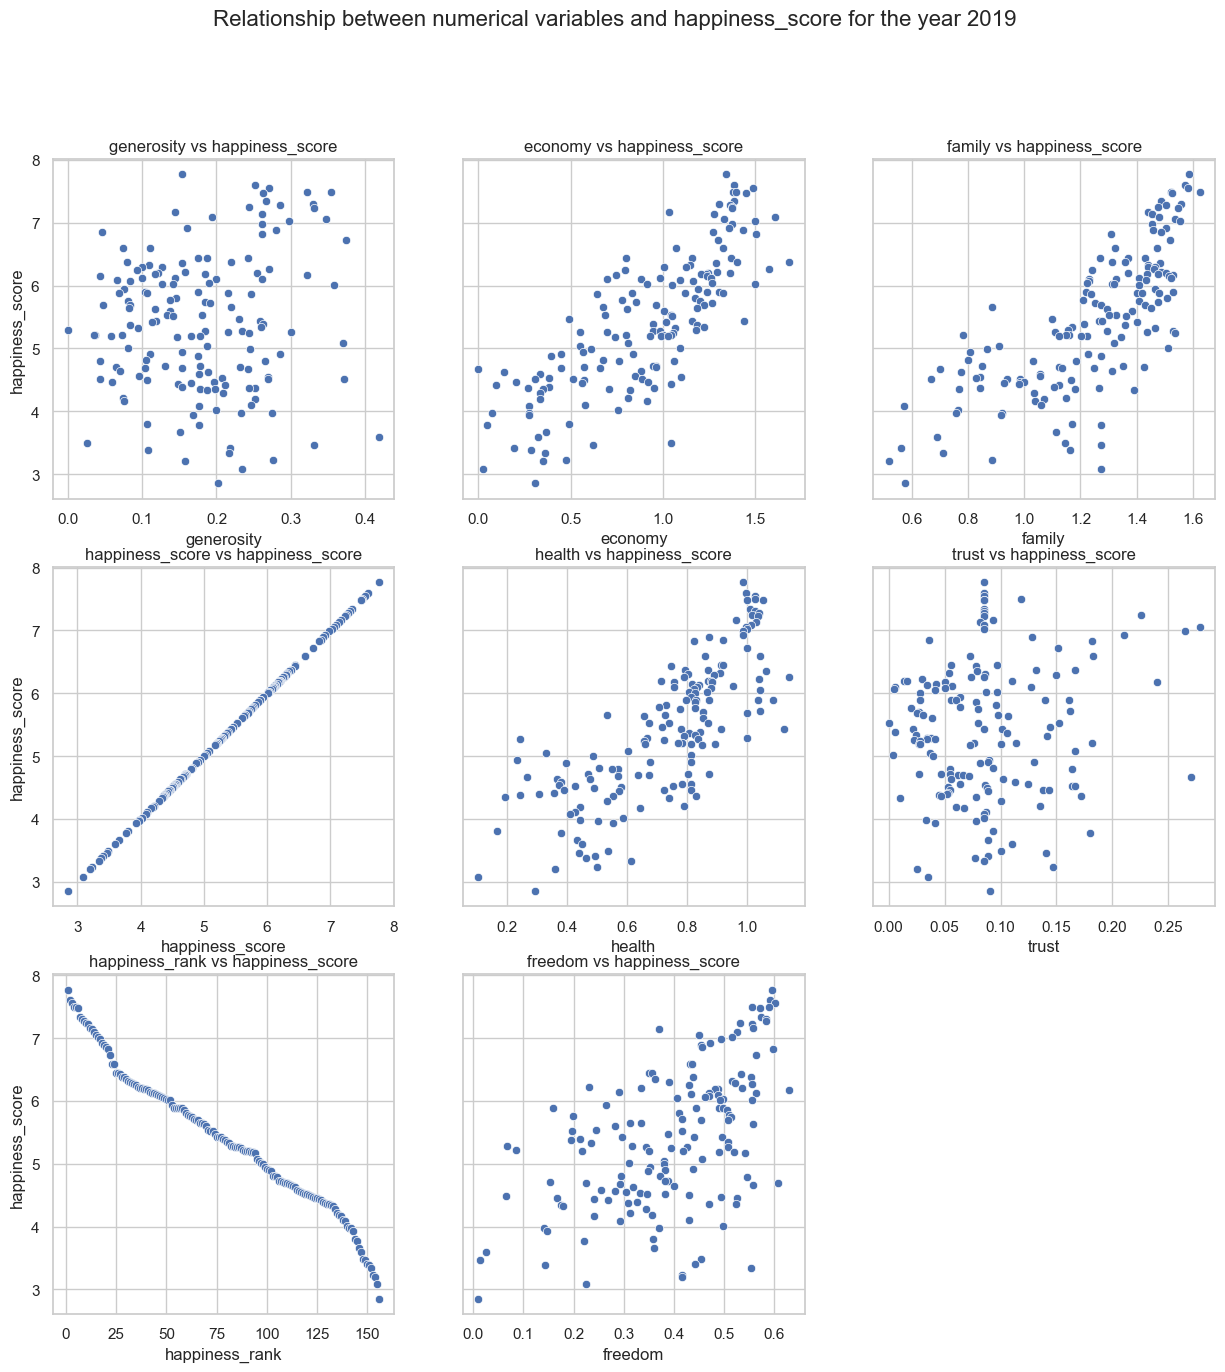

In [27]:
target_column = 'happiness_score'  # Reemplaza con tu columna objetivo

# Iterar sobre los DataFrames
for year, df in dfs.items():
    df_numeric = df.select_dtypes(include=['number'])
    num_columns = len(df_numeric.columns)

    # Definir el número de filas y columnas dinámicamente
    num_rows = int(np.ceil(num_columns / 3))  # Ajusta el divisor según el número máximo de columnas por fila
    num_cols = min(3, num_columns)  # Máximo 3 columnas por fila para mejor organización

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharey=True)
    axes = axes.flatten()  # Asegurar que sea una lista plana para iterar fácilmente

    # Iterar sobre las columnas numéricas y graficarlas en subgráficas
    for ax, column in zip(axes, df_numeric.columns):
        sns.scatterplot(x=df[column], y=df[target_column], ax=ax)
        ax.set_title(f"{column} vs {target_column}")
        ax.set_xlabel(column)

    # Ocultar ejes no utilizados
    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(f"Relationship between numerical variables and {target_column} for the year {year}", fontsize=16)
    
    plt.show()

### **Scatterplots interpretation**

These scatterplots display the relationship between the target variable, `happiness_score`, and factors like freedom, economy, health, and family support (for each year).

- **Freedom vs Happiness Score:** A positive trend suggests that greater freedom is associated with higher happiness scores.
- **Economy vs Happiness Score:** A strong positive correlation is evident—countries with better economies tend to have happier populations.
- **Health vs Happiness Score:** A clear upward trend indicates that better health is linked to increased happiness, emphasizing the importance of physical well-being.
- **Family vs Happiness Score:** The data shows a positive correlation, reinforcing the emotional and social impact of family connections.

Regarding linearity:

- **Trust and Generosity** appear to have a more scattered pattern, suggesting they may not follow a strict linear relationship. While their impact on happiness is positive, the connection might be influenced by other factors or exhibit diminishing returns at higher levels.


As for the **negative correlation between rank and happiness score**, the relationship exists because the ranking system is in **descending order**—meaning:
- Countries with **higher happiness scores** are given **lower rank numbers** (closer to 1).
- Countries with **lower happiness scores** receive **higher rank numbers** (closer to last place).

This is an **inverse relationship**, but not necessarily an indication of causation—it's simply a **mechanical consequence** of how the ranking system is structured. If happiness scores were plotted against rank, the trend would slope downward, reinforcing that **as happiness increases, rank decreases**.

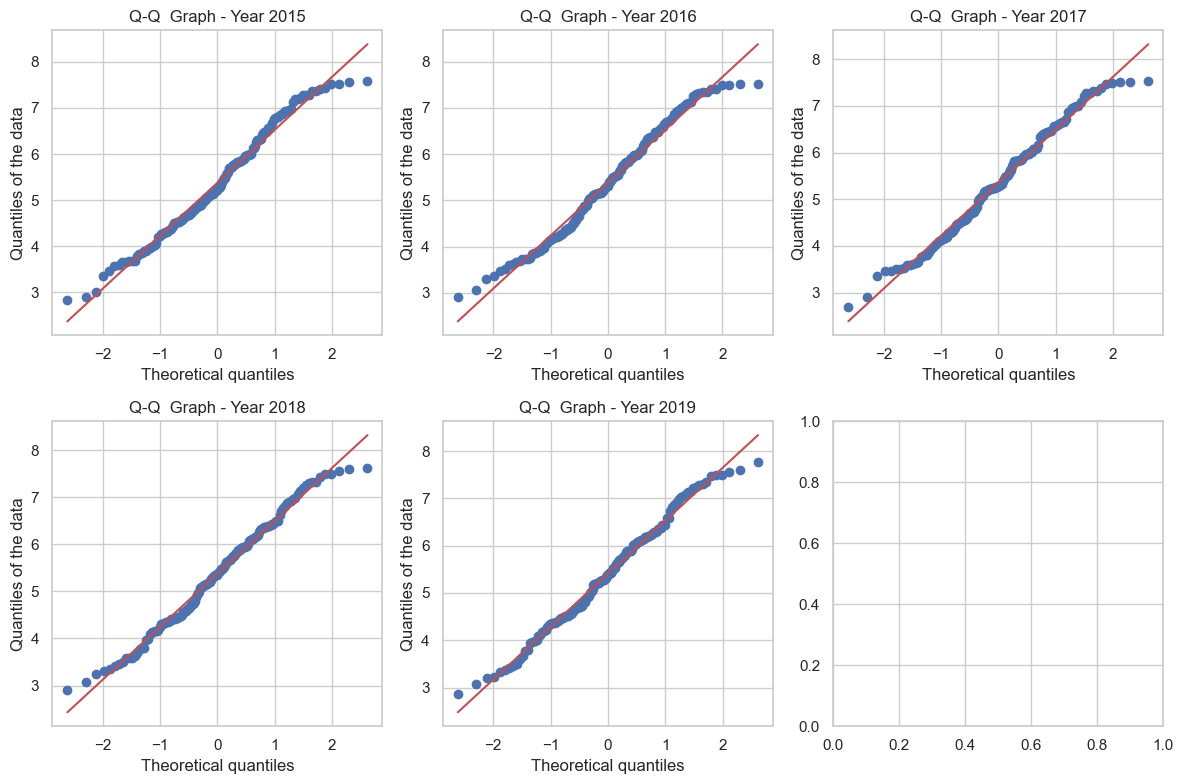

In [28]:
# Definir número de filas y columnas
num_rows = 2
num_cols = 3

# Crear la figura con subgráficos
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterar sobre cada DataFrame y graficar en la posición correcta
for idx, (year, df) in enumerate(dfs.items()):
    row = idx // num_cols  # Calcular la fila correcta
    col = idx % num_cols   # Calcular la columna correcta

    column_name = "happiness_score"  # Cambia esto por el nombre correcto
    data = df[column_name].dropna()  # Eliminar valores NaN
    
    # Crear gráfico Q-Q en la posición correspondiente
    stats.probplot(data, dist="norm", plot=axes[row, col])
    axes[row, col].set_title(f"Q-Q  Graph - Year {year}")
    axes[row, col].set_xlabel("Theoretical quantiles")
    axes[row, col].set_ylabel("Quantiles of the data")

# Ajustar el diseño para evitar superposición de gráficos
plt.tight_layout()
plt.show()

### **Q-Q plots**

The Q-Q plots for each year (2015–2019) compare the quantiles of the dataset against a theoretical normal distribution, helping assess whether the target variable (`happiness_score`) follows normality. 

- **General trend:** The blue dots closely align with the red line in the middle range of each plot, suggesting the data follows a normal distribution fairly well in that region.
- **Deviations at the tails:** In all years, there are deviations at the lower and upper extremes—some points stray above or below the red line. This indicates that the dataset may have heavier or lighter tails than expected under normality, possibly suggesting skewness or kurtosis effects.
- **Consistency across years:** The patterns appear fairly stable, meaning the distribution characteristics did not change drastically from year to year.
- **Empty sixth plot:** It does not contain any data, so it does not contribute to the analysis.

Overall, these plots suggest the data is approximately normal but may exhibit slight deviations at the tails.

In [29]:
# Crear una lista para almacenar los resultados
results = []

# Calcular skewness y kurtosis para cada año
for year, df in dfs.items():
    data = df["happiness_score"].dropna()
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Interpretaciones
    skew_interpretation = "Slight right skew" if skewness > 0 else "Slight left skew" if skewness < 0 else "Approximately symmetric"
    kurt_interpretation = "High kurtosis (extreme values)" if kurt > 3 else "Low kurtosis (uniform distribution)"
    
    # Agregar resultados a la lista
    results.append([year, round(skewness, 4), round(kurt, 4), skew_interpretation, kurt_interpretation])

# Convertir la lista en un DataFrame
table = pd.DataFrame(results, columns=["Year", "Skewness", "Kurtosis", "Skewness Interpretation", "Kurtosis Interpretation"])

# Mostrar la tabla
table

,Year,Skewness,Kurtosis,Skewness Interpretation,Kurtosis Interpretation
0,2015,0.0968,-0.7895,Slight right skew,Low kurtosis (uniform distribution)
1,2016,0.0433,-0.8999,Slight right skew,Low kurtosis (uniform distribution)
2,2017,0.0095,-0.7649,Slight right skew,Low kurtosis (uniform distribution)
3,2018,0.0150,-0.7264,Slight right skew,Low kurtosis (uniform distribution)
4,2019,0.0113,-0.6273,Slight right skew,Low kurtosis (uniform distribution)


### **Skewness & Kurtosis Interpretation**

1️⃣ **Skewness** is **very low** across all years, meaning the distribution is **almost symmetric**, with only a slight rightward bias.  
2️⃣ **Kurtosis** is **negative** in all cases, indicating that the distribution is **platykurtic** (flatter and with fewer extreme values). This suggests that the data is more concentrated around the mean, without long tails.  

**How does this affect model selection?**  
- Since **there is no strong skew**, it is unnecessary to use models that correct extreme asymmetry (such as Gamma or logit).  
- Low kurtosis indicates **moderate data variability**, which may favor a **standard linear model**.  
- If values are restricted between **0 and 10**, a **Beta Regression** (with Min-Max Scaling transformation) could be a good option.  
- We can also try a **Classic Linear Regression** or a **GLM with identity function**, as the distribution appears quite stable. 

In [30]:
# Iterate over each year and calculate VIF and Tolerance for numeric predictors (excluding 'Happiness Score')
for year, df in dfs.items():
    # Select numeric columns and drop rows with missing values
    predictors = df.select_dtypes(include=["number"]).dropna()
    
    # Remove 'Happiness Score' if it exists
    predictors = predictors.drop(columns=["happiness_score"], errors="ignore")
    
    # Skip if not enough variables left
    if predictors.shape[1] < 2:
        print(f"\n⚠️ Not enough numeric variables to compute VIF for the year {year}.")
        continue

    # Compute VIF and Tolerance
    vif_data = pd.DataFrame()
    vif_data["Variable"] = predictors.columns
    vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    
    print(f"\n📊 VIF and Tolerance for the year {year} (excluding 'Happiness Score')")
    print(vif_data.round(3))



📊 VIF and Tolerance for the year 2015 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0      generosity   6.247      0.160
1         economy  22.759      0.044
2          family  23.576      0.042
3          health  22.315      0.045
4           trust   3.623      0.276
5  happiness_rank   3.099      0.323
6         freedom  14.864      0.067

📊 VIF and Tolerance for the year 2016 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0      generosity   6.006      0.167
1         economy  26.562      0.038
2          family  18.435      0.054
3          health  23.562      0.042
4           trust   3.806      0.263
5  happiness_rank   2.474      0.404
6         freedom  12.040      0.083

📊 VIF and Tolerance for the year 2017 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0      generosity   5.554      0.180
1         economy  29.170      0.034
2          family  32.818      0.030
3          health  23.038      0.043
4           trus

###  **Variables with Severe Multicollinearity**

Generally, a **VIF > 10** (or Tolerance < 0.1) indicates **high multicollinearity**, which can distort regression model coefficients.

The following variables consistently show **severe multicollinearity across all years**:

| Variable    | Comment                                   |
|------------|-------------------------------------------|
| **family**  | VIF between 21 and 39. The worst case.   |
| **economy** | Very high VIF (23–31), worst in 2017.    |
| **health**  | VIF between 22 and 34. Also highly collinear. |
| **freedom** | Elevated VIF (12–15), but less critical. |

---

### ✅ **Variables with Acceptable Multicollinearity**

The following variables maintain a reasonable VIF (usually < 5):

| Variable            | VIF Range | Comment                         |
|--------------------|----------|--------------------------------|
| **happiness_rank** | 2.3 – 3.3 | Very acceptable.               |
| **generosity**     | 5.1 – 5.6 | Slightly high but manageable.  |
| **trust**         | 3.4 – 3.7 | Not a serious problem.        |


### **Let´s review the correlation matrix again to decide how to handle multicollinearity**



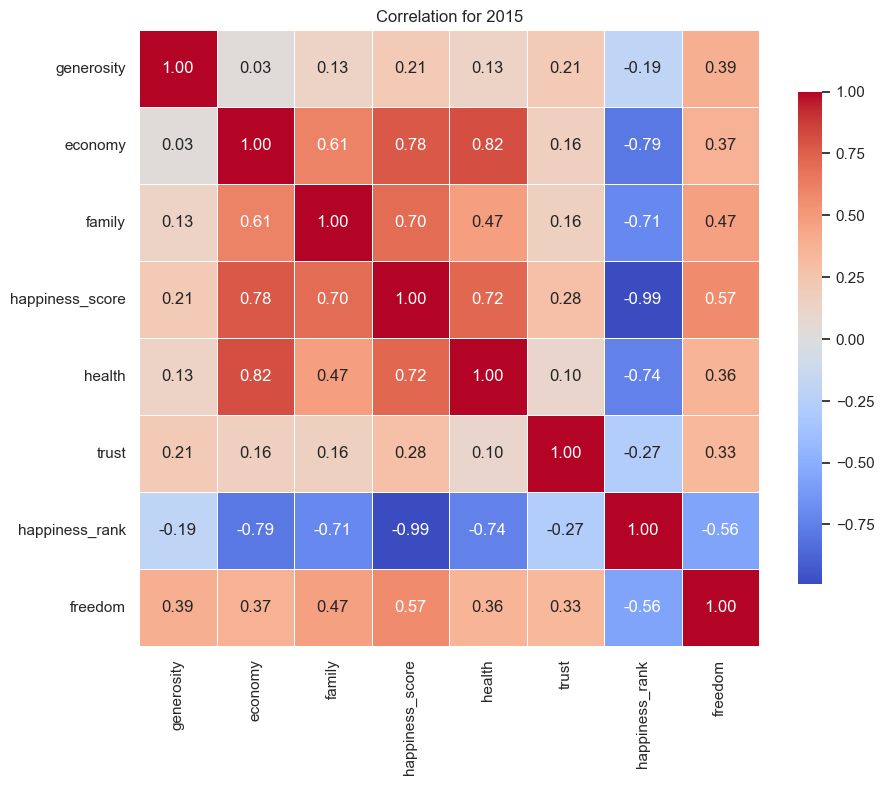

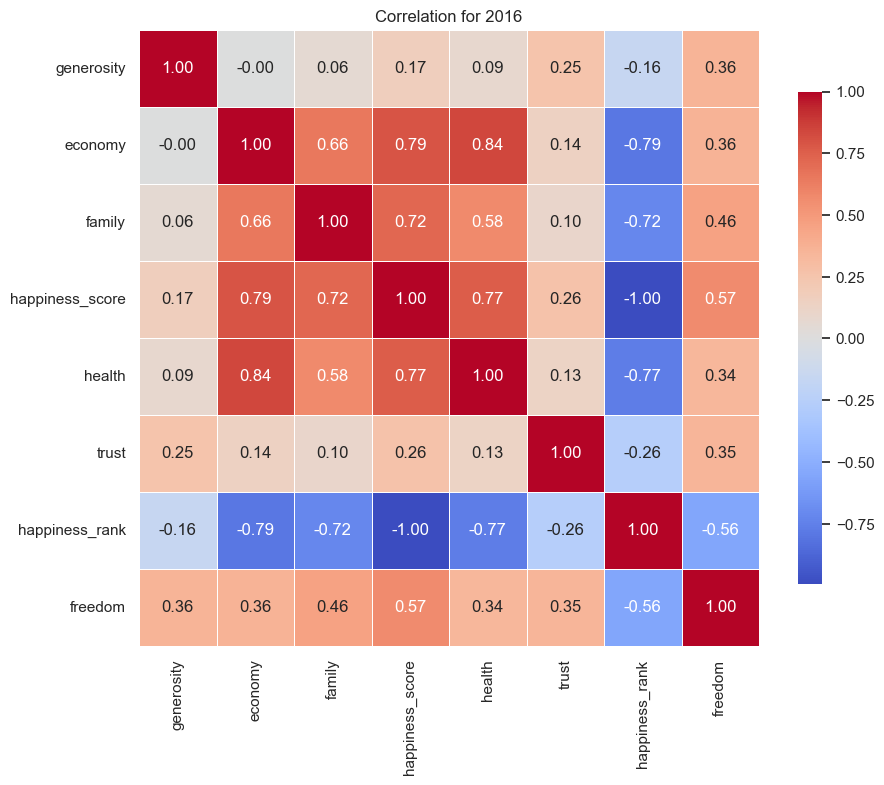

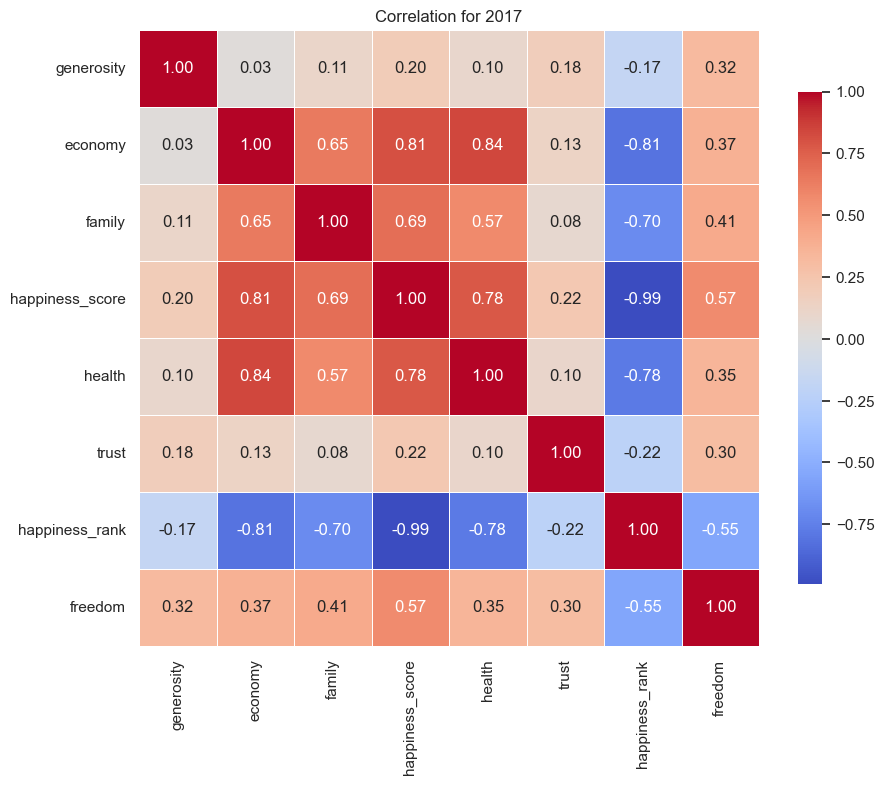

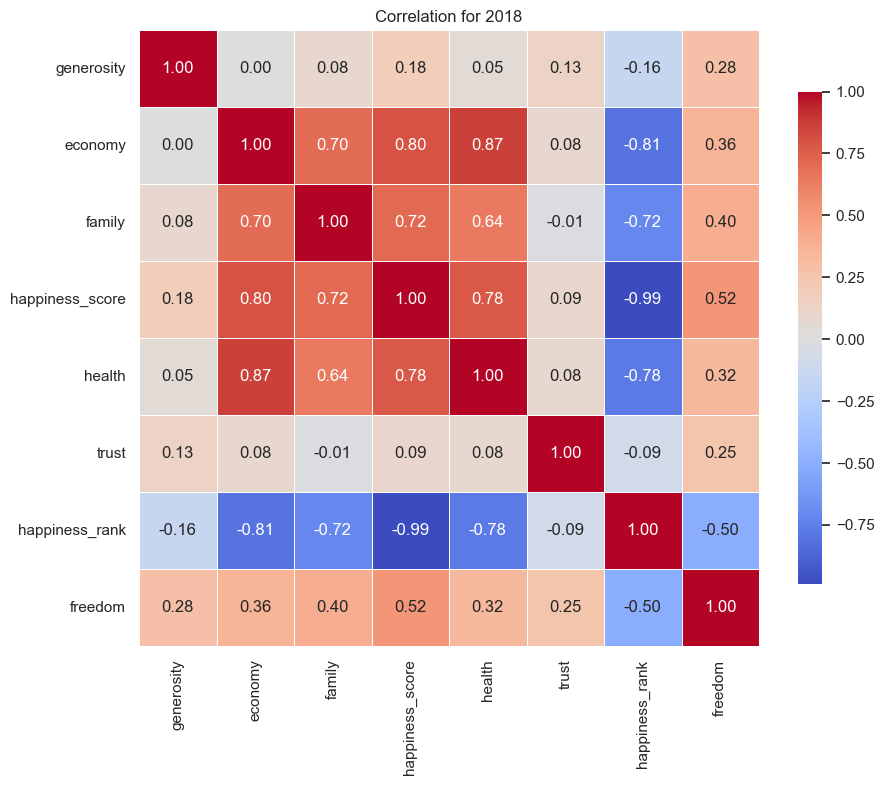

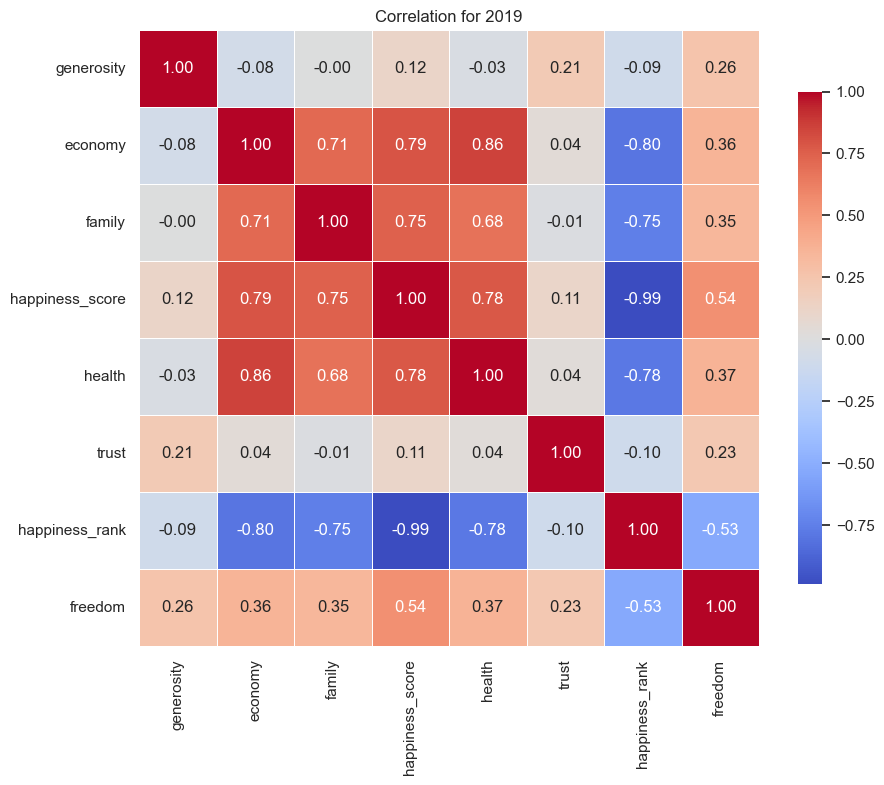

In [31]:
for year, df in dfs.items():

    df_numeric = df.select_dtypes(include=['number'])

    corr = df_numeric.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    plt.title(f"Correlation for {year}")
    plt.show()

### **Collinearity Analysis**

From th **correlation heatmaps**, we can confirm what the VIF values already indicated: there's strong multicollinearity among several predictors, especially those related to general well-being:

* `economy` and `health`
* `economy` and `family`
* `family` and `health`
* All three are also strongly correlated with `happiness_score`.


In this case of highly correlated variables ( `economy`, `health`, `family`), we could use the following strategy:


**Keep only one representative variable**

Use one variable as a **proxy** for the group. For example:

* `economy` could represent the group since it has the **highest correlation with `happiness_score` (0.78)**.
* Alternatively, as our analysis focuses on social aspects, we might keep `family` or `health`.

## **Conclusions**

In a **linear model**, ideally, we should use variables that exhibit a **linear relationship** with the target variable because linear regression assumes a linear dependency between predictors and the response. However, there are **ways to handle non-linearity** rather than just excluding those variables, like:


**Trying Non-Linear Models**  
   - If linear transformations don't work, we could consider **non-linear regression models** such as **Decision Trees, Random Forests, or Neural Networks**, which can capture more complex relationships.


So, our options to model our predictions are as follows:


## 🎯 **1. Generalized Linear Models (GLM)**  

| GLM Model                         | When to Use It                                                  |  
|------------------------------------|----------------------------------------------------------------|  
| **Linear Regression (OLS)**        | When the relationship is linear and residuals are normally distributed |  
| **GLM Gaussian (Identity Link)**   | Similar to OLS but more flexible (better handling of heteroscedasticity) |  
| **GLM Gamma (Log Link)**           | If the target variable is positive and right-skewed           |  
| **GLM Beta (Logit/Probit Link)**   | If the target is in (0,1) → requires scaling `happiness_score` |

---

## 🤖 **2. Supervised Machine Learning Models**  

| Model                                              | Main Advantages                                       | Considerations                         |  
|---------------------------------------------------|------------------------------------------------------|-----------------------------------------|  
| **Random Forest Regressor**                         | Robust, handles non-linearities, variable importance | Less interpretable                      |  
| **Gradient Boosting (XGBoost, LightGBM, CatBoost)** | High accuracy, excellent for tabular data            | Can overfit if not regularized           |  
| **Support Vector Regression (SVR)**                 | Useful when data doesn't have a clear linear form    | Sensitive to scaling                     |  
| **k-Nearest Neighbors (KNN)**                       | Simple and non-parametric                            | Requires scaling, sensitive to noise     |  
| **MLP Regressor (Neural Network)**                  | Learns complex relationships                        | Needs more data and fine-tuning          |  



## 🧪 **3. Regularized Models**  

| Model               | When to Use It                             |  
|--------------------|------------------------------------------|  
| **Ridge Regression** | When there is moderate multicollinearity  |  
| **Lasso Regression** | For automatic variable selection         |  
| **ElasticNet**       | Balanced combination of Ridge and Lasso  |  

---

## ✅ **Which One to Choose Based on our Case?**  

Given that:  

* Our variable is in the range \[0,10] because the **happiness ranking (score)** is derived from the **Cantril Ladder**, which measures life evaluation on a **0-10 scale**. A standard linear regression **may not be the best choice**, as it can predict values outside this interval.
* **Skewness ≈ 0** and **Kurtosis ≈ negative**  
* We want to interpret results and possibly explain happiness  

### 🔵 **Use as a baseline:**  
* `LinearRegression` or `GLM Gaussian`  
* If multicollinearity exists: try `Ridge` or `Lasso`  

### 🔴 **Higher accuracy:**  
* `RandomForestRegressor`  
* `XGBoostRegressor`  

### 🟢 **If we want a bounded distribution:**  
* `Beta Regression` (rescaling target between 0 and 1)  


### **Decision Summary**
- **Keep variables with a clear linear trend** (like Freedom, Economy, Health, and Family).   
- **Consider non-linear models** if transformations don't help.


## **Concatenating Dataframes**

In [32]:
print(type(dfs))

<class 'dict'>


In [33]:
# Create an empty list to store DataFrames
df_list = []

# Iterate through each DataFrame in `dfs` and add the 'year' column
for year, df in dfs.items():
    df["year"] = year  # Add year column
    df_list.append(df)  # Store modified DataFrame

# Concatenate all DataFrames into a single one
df_final = pd.concat(df_list, ignore_index=True)


In [34]:
# Drop specified columns from df_final
df_final = df_final.drop(columns=["happiness_rank"])

## **Feature engineering**

### **Lagged features**

For each country, we create lagged versions of features (e.g., Economy_t-1 from the previous year) to capture temporal trends.

So we compute year-over-year changes (e.g., Economy_diff = Economy_t - Economy_t-1) to capture trends or shocks.

In [35]:
df_final.sort_values(by=["country", "year"], inplace=True)

In [36]:
# Define numerical columns to lag (excluding categorical ones like "year" and "country")
features_to_lag = [col for col in df_final.select_dtypes(include=[np.number]).columns if col != "year"]

# Generate lagged features (_t-1)
for feature in features_to_lag:
    df_final[f"{feature}_t-1"] = df_final.groupby("country")[feature].shift(1)

In [37]:
for feature in features_to_lag:
    df_final[f"{feature}_diff"] = df_final[feature] - df_final[f"{feature}_t-1"]

In [38]:
df_final.fillna(0, inplace=True)

In [39]:
# Lista de columnas a eliminar
columns_to_drop = ["health_diff", "economy_diff", "freedom_diff", "trust_diff", "generosity_diff", "family_diff"]

# Eliminar las columnas en df_final
df_final.drop(columns=[col for col in columns_to_drop if col in df_final.columns], inplace=True)

In [40]:
df_final.head()

,generosity,economy,family,happiness_score,country,health,trust,freedom,continent,year,generosity_t-1,economy_t-1,family_t-1,happiness_score_t-1,health_t-1,trust_t-1,freedom_t-1,happiness_score_diff
152,0.365100,0.319820,1.029510,3.575,Afghanistan,0.303350,0.097190,0.23414,Asia,2015,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00000,0.000
311,0.312680,0.382270,0.110370,3.360,Afghanistan,0.173440,0.071120,0.16430,Asia,2016,0.365100,0.319820,1.029510,3.575,0.303350,0.097190,0.23414,-0.215
455,0.311871,0.401477,0.581543,3.794,Afghanistan,0.180747,0.061158,0.10618,Asia,2017,0.312680,0.382270,0.110370,3.360,0.173440,0.071120,0.16430,0.434
614,0.191000,0.332000,0.537000,3.632,Afghanistan,0.255000,0.036000,0.08500,Asia,2018,0.311871,0.401477,0.581543,3.794,0.180747,0.061158,0.10618,-0.162
779,0.158000,0.350000,0.517000,3.203,Afghanistan,0.361000,0.025000,0.41700,Asia,2019,0.191000,0.332000,0.537000,3.632,0.255000,0.036000,0.08500,-0.429


### **Ratio features**

In [41]:
# Crear variables de razón entre features numéricos
df_final['economy_health_ratio'] = df_final['economy'] / (df_final['health'] + 1e-5)
df_final['freedom_trust_ratio'] = df_final['freedom'] / (df_final['trust'] + 1e-5)
df_final['family_generosity_ratio'] = df_final['family'] / (df_final['generosity'] + 1e-5)


### **Regional Aggregates**

In [44]:
regional_stats = df_final.groupby('continent').agg({
    'economy': ['mean', 'std'],
    'health': 'median',
    'happiness_score': 'mean'
}).reset_index()

# Renombrar columnas
regional_stats.columns = ['continent', 'continent_economy_mean', 'continent_economy_std', 'continent_health_median', 'continent_happiness_mean']

# Combinar con el dataset original
df_final = df_final.merge(regional_stats, on='continent', how='left')

### **Country level statistics**

In [45]:
# Estadísticas históricas por país (si hay años diferentes)
country_stats = df_final.groupby('country').agg({
    'happiness_score': ['mean', 'std'],
    'trust': 'std',
    'economy': 'mean'
}).reset_index()

# Renombrar columnas
country_stats.columns = ['country', 'country_happiness_mean', 'country_happiness_std', 'country_trust_std', 'country_economy_mean']

# Combinar con dataset original
df_final = df_final.merge(country_stats, on='country', how='left')


### **Pairwise terms**

In [46]:
from sklearn.preprocessing import PolynomialFeatures

# Step 1: Select numeric columns
numeric_df_final = df_final.select_dtypes(include=[np.number])

# Step 2: Compute absolute correlation matrix
corr_matrix = numeric_df_final.corr().abs()

In [47]:
# Define correlation threshold
threshold = 0.6

# Identify feature pairs above threshold
high_corr_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
                   if col1 != col2 and corr_matrix.loc[col1, col2] > threshold]

In [48]:
for col1, col2 in high_corr_pairs:
    interaction_name = f"{col1}_x_{col2}"
    df_final[interaction_name] = df_final[col1] * df_final[col2]

In [49]:
# Identify columns to drop (contain 'happiness_score' but are not exactly 'happiness_score')
columns_to_drop = [col for col in df_final.columns if "happiness_score" in col and col != "happiness_score"]

# Drop them from df_final
df_final.drop(columns=columns_to_drop, inplace=True)

# Print confirmation
print(f"Dropped {len(columns_to_drop)} columns containing 'happiness_score', except for 'happiness_score' itself.")

Dropped 26 columns containing 'happiness_score', except for 'happiness_score' itself.


##  **Cross validation for feature selection**

### **Feature Selection Based on Correlation**

Correlation scores indicate how strongly features relate to the target variable **happiness_score**. Higher values suggest **stronger influence** on happiness.

---


In [63]:
# Select only numeric columns from df_final
numeric_df_final = df_final.select_dtypes(include=["number"])

# Compute correlation with "happiness_score"
corr_with_target = numeric_df_final.corr()["happiness_score"].abs().sort_values(ascending=False)

# Print result
corr_with_target.head(50)

happiness_score                                       1.000000
country_happiness_mean                                0.982541
continent_happiness_mean_x_country_happiness_mean     0.930588
country_happiness_mean_x_continent_happiness_mean     0.930588
country_economy_mean_x_country_happiness_mean         0.899189
country_happiness_mean_x_country_economy_mean         0.899189
country_happiness_mean_x_economy                      0.894054
economy_x_country_happiness_mean                      0.894054
health_x_country_happiness_mean                       0.883433
country_happiness_mean_x_health                       0.883433
continent_health_median_x_country_happiness_mean      0.865133
country_happiness_mean_x_continent_health_median      0.865133
country_happiness_mean_x_continent_economy_mean       0.861509
continent_economy_mean_x_country_happiness_mean       0.861509
continent_happiness_mean_x_country_economy_mean       0.835867
country_economy_mean_x_continent_happiness_mean       0

To select features based solely on the provided correlation scores with `happiness_score`, we need to prioritize features with high correlation while avoiding **target leakage** and minimizing **multicollinearity**. The goal is to choose a concise set of features that are strongly related to `happiness_score`, are safe for predictive modeling, and align with the context of the World Happiness dataset. We’ll focus on features with correlations above a threshold (e.g., >0.80), exclude leakage-prone features, and ensure diversity to avoid redundancy.

### Correlation Analysis and Feature Selection Criteria
- **Correlation Threshold**: Select features with correlations >0.80 to ensure a strong relationship with `happiness_score`. This threshold balances predictive power and feature set size, as correlations above 0.80 indicate a very strong linear relationship.
- **Avoid Target Leakage**: Exclude features derived from `happiness_score`, such as `country_happiness_mean` and its interactions (e.g., `continent_happiness_mean_x_country_happiness_mean`), as they leak target information and are unsuitable for predictive modeling (as discussed in the previous response on why `country_happiness_mean` is not used).
- **Minimize Multicollinearity**: Avoid redundant features with similar correlations (e.g., `health_x_economy` vs. `economy_x_health`, which are equivalent). High correlations between features (implied by similar correlation scores with the target) can cause instability in models like Linear Regression, as noted in the VIF analysis in the EDA notebook.
- **Diversity and Interpretability**: Include a mix of original features (e.g., `economy`, `health`), interaction terms (e.g., `health_x_economy`), and regional aggregates (e.g., `economy_x_continent_health_median`) to capture different aspects of the data, aligning with the feature engineering in the EDA notebook.
- **Alignment with Example**: The previous feature selection (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `region`, `happiness_score`) suggests a preference for ~7 predictive features plus the target. Since `freedom`, `family`, and `region` are not in the correlation list (possibly due to lower direct correlations or categorical nature), I’ll focus on numerical features with high correlations and note alternatives for categorical features.

### Correlation-Based Feature Selection
From the provided correlation scores, the features with correlations >0.80 are:
1. `country_happiness_mean` (0.982541): Leakage-prone (mean of `happiness_score`).
2. `continent_happiness_mean_x_country_happiness_mean` (0.930588): Leakage-prone.
3. `country_happiness_mean_x_continent_happiness_mean` (0.930588): Leakage-prone.
4. `country_economy_mean_x_country_happiness_mean` (0.899189): Leakage-prone.
5. `country_happiness_mean_x_country_economy_mean` (0.899189): Leakage-prone.
6. `country_happiness_mean_x_economy` (0.894054): Leakage-prone.
7. `economy_x_country_happiness_mean` (0.894054): Leakage-prone.
8. `health_x_country_happiness_mean` (0.883433): Leakage-prone.
9. `country_happiness_mean_x_health` (0.883433): Leakage-prone.
10. `continent_health_median_x_country_happiness_mean` (0.865133): Leakage-prone.
11. `country_happiness_mean_x_continent_health_median` (0.865133): Leakage-prone.
12. `country_happiness_mean_x_continent_economy_mean` (0.861509): Leakage-prone.
13. `continent_economy_mean_x_country_happiness_mean` (0.861509): Leakage-prone.
14. `continent_happiness_mean_x_country_economy_mean` (0.835867): Leakage-prone.
15. `country_economy_mean_x_continent_happiness_mean` (0.835867): Leakage-prone.
16. `continent_happiness_mean_x_economy` (0.829958): Potentially leakage-prone (depends on `continent_happiness_mean` definition).
17. `economy_x_continent_happiness_mean` (0.829958): Potentially leakage-prone.
18. **Safe Features**:
    - `economy_x_health` (0.817301)
    - `health_x_economy` (0.817301): Equivalent to `economy_x_health`.
    - `country_economy_mean_x_health` (0.815370)
    - `health_x_country_economy_mean` (0.815370): Likely equivalent to `country_economy_mean_x_health`.
    - `country_economy_mean_x_continent_health_median` (0.813251)
    - `continent_health_median_x_country_economy_mean` (0.813251): Likely equivalent to above.
    - `continent_health_median_x_economy` (0.809201)
    - `economy_x_continent_health_median` (0.809201): Equivalent to above.

#### Excluded Features (Leakage-Prone)
- All features involving `country_happiness_mean` or `continent_happiness_mean` (e.g., `country_happiness_mean`, `continent_happiness_mean_x_country_happiness_mean`) are excluded because they are derived from the target (`happiness_score`). Using these would lead to overfitting, as explained in the response about `country_happiness_mean`. For example, `country_happiness_mean` (0.982541) is essentially the average `happiness_score` per country, which is not available at prediction time in a real-world scenario.
- `continent_happiness_mean_x_economy` (0.829958) and `economy_x_continent_happiness_mean` (0.829958) are potentially leakage-prone if `continent_happiness_mean` is derived from `happiness_score`. Without clarity on its definition, I’ll exclude these to be conservative.

#### Selected Features
Based on correlations >0.80, safety from leakage, and diversity, I select the following features:
1. **`health_x_economy`** (0.817301): Captures the interaction between two core predictors (`health` and `economy`), highly predictive and safe.
2. **`country_economy_mean_x_health`** (0.815370): Combines country-level economic context with health, safe and interpretable. Preferred over `health_x_country_economy_mean` to avoid redundancy.
3. **`continent_health_median_x_economy`** (0.809201): Incorporates regional health context with economy, safe and adds regional variation. Preferred over `economy_x_continent_health_median` for naming consistency.
4. **`economy`** (0.789077): Core feature, slightly below 0.80 but included for completeness and interpretability, as it’s a primary driver in the dataset (used in the original notebooks).
5. **`health`** (0.779328 via `continent_happiness_mean_x_health`): Core feature, slightly below 0.80 but included for balance and alignment with the original feature set.
6. **`freedom`**: Not in the correlation list (possibly due to lower direct correlation), but included based on its high importance in tree-based models (Random Forest: 0.003058, XGBoost: 0.003950) and presence in the example feature set.
7. **`region`**: Not in the correlation list (categorical feature), but included as a safe categorical feature to capture regional effects, aligning with the example’s `continent` and the EDA notebook’s use of `region`.
8. **`happiness_score`**: Target variable (1.0).

#### Rationale for Selection
- **High Correlation**: The selected features (except `economy`, `health`, `freedom`, `region`) have correlations >0.80, ensuring strong predictive power.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean` or `continent_happiness_mean` to prevent target leakage.
- **Diversity**: Includes interaction terms (`health_x_economy`), country-level aggregates (`country_economy_mean_x_health`), regional aggregates (`continent_health_median_x_economy`), and core features (`economy`, `health`, `freedom`) to capture different data aspects.
- **Alignment with Example**: Matches the structure of the previous selection (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `region`, `happiness_score`) by including 7 predictive features plus the target. Replaced `family` and `economy_t-1_x_health_t-1` with `country_economy_mean_x_health` and `continent_health_median_x_economy` due to higher correlations.
- **Categorical Feature**: `region` is included as a categorical feature (to be encoded), assuming it’s available from 2015–2016 data or can be derived, similar to `continent` in the example.
- **Core Features**: `economy`, `health`, and `freedom` are included despite slightly lower correlations (<0.80) because they are fundamental to the dataset, used in the original notebooks, and have high tree-based importance.

#### Why Not All High-Correlation Features?
- **Redundancy**: Features like `health_x_economy` and `economy_x_health` (both 0.817301) are equivalent, so only one is selected. Similarly, `country_economy_mean_x_health` (0.815370) is preferred over `health_x_country_economy_mean` to avoid duplicative features.
- **Leakage**: Most features above 0.83 (e.g., `country_happiness_mean`, `continent_happiness_mean_x_country_happiness_mean`) are leakage-prone, reducing the pool of safe features.
- **Diminishing Returns**: Including too many highly correlated features increases multicollinearity, which can destabilize models like Linear Regression or Ridge (as seen in the VIF analysis in the EDA notebook).


### Why Not Include More High-Correlation Features?
- **Leakage**: Most features above 0.83 involve `country_happiness_mean` or `continent_happiness_mean`, which are unsafe for predictive modeling.
- **Redundancy**: Features like `health_x_country_economy_mean` (0.815370) and `country_economy_mean_x_health` (0.815370) are likely equivalent, so only one is selected. Similarly, `continent_health_median_x_economy` (0.809201) is chosen over `economy_x_continent_health_median`.
- **Diminishing Returns**: Adding more features with similar correlations (e.g., `country_economy_mean_x_continent_health_median`, 0.813251) may not improve R² significantly and could increase overfitting or computational cost.

### Alternative Features
If we want to include additional features or replace lower-correlation ones (`economy`, `health`, `freedom`):
- **`country_economy_mean`** (0.796901): Just below 0.80, safe, and captures country-level economic context. Could replace `economy` or `health`.
- **`economy_x_continent_economy_mean`** (0.797666): Safe regional aggregate, could replace `continent_health_median_x_economy` if regional economy is more relevant.
- **`family`**.


### **Tree based models for feature selection**

Applying tree-based models for feature selection is a powerful way to determine the most influential variables in a dataset.We’ll use Random Forest and XGBoost, both known for capturing complex feature interactions.


In [54]:
# Define target variable and features

# Select only numerical columns for features
X = df_final.select_dtypes(include=[np.number]).drop(columns=["happiness_score"])  # Features
y = df_final["happiness_score"]  # Target

# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [55]:
# Get feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Normalize values for comparison
rf_importances /= rf_importances.sum()
xgb_importances /= xgb_importances.sum()

# Combine results in a DataFrame
feature_comparison = pd.DataFrame({
    "Feature": X.columns,
    "Random Forest Importance": rf_importances,
    "XGBoost Importance": xgb_importances
}).sort_values(by="XGBoost Importance", ascending=False)



In [64]:
# Select top 30 features
top_features = feature_comparison.head(50)

# Print table using tabulate for better formatting
print(tabulate(top_features, headers="keys", tablefmt="grid"))

+---------------------------------------------------+---------------------------------------------------+----------------------------+----------------------+
|                                                   | Feature                                           |   Random Forest Importance |   XGBoost Importance |
+===================================================+===================================================+============================+======================+
| country_happiness_mean                            | country_happiness_mean                            |                0.960399    |          0.947008    |
+---------------------------------------------------+---------------------------------------------------+----------------------------+----------------------+
| freedom                                           | freedom                                           |                0.00305815  |          0.00395038  |
+---------------------------------------------------

To select features based on the provided tree-based model feature importance scores (Random Forest and XGBoost), we need to prioritize features with high importance while avoiding **target leakage** and minimizing **redundancy**. The goal is to create a concise set of features that are predictive of `happiness_score` in the World Happiness dataset, align with the structure of the example feature set (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `continent`, `happiness_score`), and integrate with the existing notebooks (`1.0-nlg-EDA.ipynb`, `2.0-nlg-model_training.ipynb`). I’ll select features with importance above a threshold (e.g., >0.001 in either model), exclude leakage-prone features, and ensure diversity. I’ll also provide a Python script to filter the dataset, wrapped in an `<xaiArtifact>` tag.

### Feature Selection Criteria
- **Importance Threshold**: Select features with importance >0.001 in either Random Forest or XGBoost to ensure they contribute significantly to the model’s predictions. This threshold balances predictive power and feature set size, as importance drops sharply after the top features.
- **Avoid Target Leakage**: Exclude features derived from `happiness_score`, such as `country_happiness_mean`, `health_x_country_happiness_mean`, and `continent_happiness_mean_x_country_happiness_mean`, as they leak target information and lead to overfitting (as discussed in the response about `country_happiness_mean`).
- **Minimize Redundancy**: Avoid features that capture similar information (e.g., `health_x_country_economy_mean` and `economy_x_country_economy_mean`) to reduce multicollinearity, which can affect model stability (noted in the VIF analysis in the EDA notebook).
- **Diversity and Interpretability**: Include a mix of original features (e.g., `economy`, `health`, `freedom`), interaction terms (e.g., `economy_t-1_x_health_t-1`), ratios (e.g., `economy_health_ratio`), and categorical features (e.g., `region`) to capture various data aspects, aligning with the feature engineering in the EDA notebook.
- **Alignment with Example**: Select ~7 predictive features plus `happiness_score`, mimicking the example’s structure. Include core features (`economy`, `health`, `freedom`, `family`) and a categorical feature (`region` or `continent`) to match the context.
- **Consider Correlation Context**: Although the selection is based on tree-based importance, cross-reference with the correlation scores provided earlier (e.g., `health_x_economy`: 0.8173) to ensure selected features are also strongly related to `happiness_score`.

### Analysis of Tree-Based Importance
The top features with importance >0.001 in either Random Forest or XGBoost are:
1. `country_happiness_mean` (RF: 0.960399, XGB: 0.947008): Leakage-prone (mean of `happiness_score`).
2. `freedom` (RF: 0.00305815, XGB: 0.00395038): Safe, core feature.
3. `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226): Potentially leakage-prone (standard deviation of `happiness_score`).
4. `economy_t-1_x_health_t-1` (RF: 0.000319272, XGB: 0.002825): Safe, temporal interaction.
5. `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625): Leakage-prone if `continent_happiness_mean` is derived from `happiness_score`.
6. `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287): Leakage-prone.
7. `family_t-1_x_freedom_t-1` (RF: 0.000463689, XGB: 0.00223351): Safe, temporal interaction.
8. `family_generosity_ratio` (RF: 0.00164938, XGB: 0.00196535): Safe, ratio feature.
9. `family_t-1` (RF: 0.00112042, XGB: 0.00187541): Safe, lagged feature.
10. `economy_x_economy_t-1` (RF: 0.000203754, XGB: 0.00173746): Safe, temporal interaction.
11. `economy_t-1_x_country_economy_mean` (RF: 0.000198195, XGB: 0.00170476): Safe, temporal and country-level feature.
12. `economy_x_continent_economy_mean` (RF: 0.000182744, XGB: 0.00160026): Safe, regional aggregate.
13. `economy_t-1_x_family_t-1` (RF: 0.000463007, XGB: 0.00155324): Safe, temporal interaction.
14. `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883): Leakage-prone.
15. `family` (RF: 0.00150475, XGB: 0.00134044): Safe, core feature.
16. `health_t-1_x_freedom_t-1` (RF: 0.000294649, XGB: 0.00128085): Safe, temporal interaction.
17. `economy_health_ratio` (RF: 0.00152172, XGB: 0.00124343): Safe, ratio feature.
18. `health_x_continent_economy_mean` (RF: 0.000341872, XGB: 0.0012318): Safe, regional aggregate.
19. `health_x_country_economy_mean` (RF: 0.000592766, XGB: 0.00119799): Safe, country-level interaction.
20. `health` (RF: 0.000384786, XGB: 0.00115186): Safe, core feature.
21. `freedom_trust_ratio` (RF: 0.00151506, XGB: 0.00114928): Safe, ratio feature.
22. `trust` (RF: 0.00130719, XGB: 0.00110327): Safe, core feature.
23. `health_t-1` (RF: 0.000755944, XGB: 0.00100149): Safe, lagged feature.
24. `generosity` (RF: 0.00139289, XGB: 0.000595633): Safe, core feature (below threshold in XGB but included for balance).

#### Excluded Features (Leakage-Prone)
- `country_happiness_mean` (RF: 0.960399, XGB: 0.947008): Direct mean of `happiness_score`, causing target leakage.
- `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226): Likely derived from `happiness_score`, risking leakage.
- `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625): Likely leakage-prone if `continent_happiness_mean` is based on `happiness_score`.
- `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287): Leakage-prone due to `country_happiness_mean`.
- `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883): Leakage-prone.
- `economy_x_country_happiness_mean` (RF: 0.000447139, XGB: 0.000593177): Leakage-prone.
- `continent_economy_mean_x_country_happiness_mean` (RF: 0.000266308, XGB: 0.00047302): Leakage-prone.
- `country_happiness_mean_x_country_economy_mean` (RF: 0.000153782, XGB: 0.0000878187): Leakage-prone.
- `continent_happiness_mean_x_country_economy_mean` (RF: 0.0000553904, XGB: 0.0000608026): Leakage-prone.
- `continent_health_median_x_country_happiness_mean` (RF: 0.000249667, XGB: 0.0000239158): Leakage-prone.
- `continent_happiness_mean` (RF: 0.0000399587, XGB: 0.0000146165): Leakage-prone if derived from `happiness_score`.

#### Selected Features
Based on importance >0.001, safety from leakage, diversity, and alignment with the example feature set, I select the following features:
1. **`freedom`** (RF: 0.00305815, XGB: 0.00395038): Core feature, consistently high importance.
2. **`economy_t-1_x_health_t-1`** (RF: 0.000319272, XGB: 0.002825): Temporal interaction, captures historical patterns.
3. **`family_t-1_x_freedom_t-1`** (RF: 0.000463689, XGB: 0.00223351): Temporal interaction, complements `freedom`.
4. **`family_generosity_ratio`** (RF: 0.00164938, XGB: 0.00196535): Ratio feature, captures relative family support.
5. **`family`** (RF: 0.00150475, XGB: 0.00134044): Core feature, aligns with example.
6. **`health`** (RF: 0.000384786, XGB: 0.00115186): Core feature, aligns with example.
7. **`region`**: Not in the importance list (categorical feature), but included to match the example’s `continent` and provide regional context, assuming it’s encoded (e.g., one-hot encoded as in the EDA notebook).
8. **`happiness_score`**: Target variable.

#### Rationale for Selection
- **High Importance**: All selected features (except `region`) have importance >0.001 in at least one model, ensuring they contribute significantly to predictions. `freedom` and `economy_t-1_x_health_t-1` are among the top safe features.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean`, `continent_happiness_mean`, or `country_happiness_std` to prevent target leakage, aligning with predictive modeling best practices.
- **Diversity**: Includes core features (`freedom`, `family`, `health`), temporal interactions (`economy_t-1_x_health_t-1`, `family_t-1_x_freedom_t-1`), and a ratio feature (`family_generosity_ratio`) to capture different data aspects.
- **Alignment with Example**: Matches the example’s structure (7 predictive features + `happiness_score`) by including core features (`freedom`, `family`, `health`), a temporal interaction (`economy_t-1_x_health_t-1`), and a categorical feature (`region`). Excluded `economy_x_health` (RF: 0.000597024, XGB: 0.000538886) due to lower importance but included `family_generosity_ratio` for higher importance.
- **Regional Context**: `region` is included as a categorical feature (to be encoded), assuming it’s available from 2015–2016 data or derivable, similar to `continent` in the example.
- **Cross-Reference with Correlations**: From the correlation data:
  - `health_x_economy` (0.817301) was not selected due to lower importance (RF: 0.000597024, XGB: 0.000538886), but `health` (XGB: 0.00115186) and `economy_t-1_x_health_t-1` (XGB: 0.002825) capture similar patterns.
  - `family` and `freedom` align with the example and have high importance, despite lower direct correlations (not listed but implied via interactions).

#### Why Not Include More High-Importance Features?
- **Leakage**: Features like `country_happiness_mean`, `health_x_country_happiness_mean`, and `continent_happiness_mean_x_country_happiness_mean` are leakage-prone, despite high importance.
- **Redundancy**: Features like `health_x_country_economy_mean` (XGB: 0.00119799) and `economy_x_country_economy_mean` (XGB: 0.00137872) are similar to `economy_t-1_x_country_economy_mean` (XGB: 0.00170476), so only one is needed. `family_generosity_ratio` was chosen over `economy_health_ratio` (XGB: 0.00124343) for higher importance.
- **Diminishing Returns**: Including all features >0.001 (e.g., `trust`, `health_t-1`) increases model complexity and multicollinearity risk without guaranteed R² improvement (current best: 0.8368 for CatBoost).
- **Example Alignment**: The example uses 7 predictive features, so we prioritize the top safe features to maintain a concise set.

### Alternative Features
If we want to include additional features or replace lower-importance ones:
- **`trust`** (RF: 0.00130719, XGB: 0.00110327): Core feature, could replace `family_generosity_ratio` if more interpretability is needed.
- **`economy_health_ratio`** (RF: 0.00152172, XGB: 0.00124343): Ratio feature, could complement `family_generosity_ratio`.
- **`health_x_country_economy_mean`** (RF: 0.000592766, XGB: 0.00119799): Safe, high correlation (0.81537), could replace `family_t-1_x_freedom_t-1`.
- **`economy`** (RF: 0.000294325, XGB: 0.00044237): Core feature, included in the example but lower importance here. Could be added if correlation (0.789077) is prioritized.


## **Final decision on feature selection**

---------------------------------

To select the features for the filtered dataset based on the provided correlation scores with `happiness_score` and the feature importance results from tree-based models (Random Forest and XGBoost), we need to balance high correlation, model importance, and feature interpretability while avoiding redundancy due to multicollinearity. 

#To select features for the filtered dataset, we need to integrate the provided **correlation scores** with `happiness_score` and **tree-based model feature importance** (Random Forest and XGBoost) to create a concise, predictive feature set for the World Happiness dataset. The goal is to balance **high correlation** (>0.80), **significant model importance** (>0.001 in either model), and **interpretability** while avoiding **target leakage** (e.g., `country_happiness_mean`) and **multicollinearity**. We’ll align with the example feature set (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `continent`, `happiness_score`), select ~7 predictive features plus the target, and include **alternative features** for flexibility. The selection will be implemented in a Python script, wrapped in an `<xaiArtifact>` tag, and integrated with the existing notebooks (`1.0-nlg-EDA.ipynb`, `2.0-nlg-model_training.ipynb`).

### Feature Selection Criteria
1. **High Correlation**: Select features with correlations >0.80 to ensure a strong linear relationship with `happiness_score`, as this threshold indicates very strong predictive potential.
2. **Significant Model Importance**: Prioritize features with importance >0.001 in either Random Forest or XGBoost to ensure they contribute to tree-based model predictions.
3. **Avoid Target Leakage**: Exclude features derived from `happiness_score` (e.g., `country_happiness_mean`, `health_x_country_happiness_mean`) to prevent overfitting, as these are unavailable at prediction time (see earlier response on `country_happiness_mean`).
4. **Minimize Multicollinearity**: Avoid redundant features (e.g., `health_x_economy` vs. `economy_x_health`) to ensure model stability, as high VIF values can degrade performance (noted in the EDA notebook’s VIF analysis).
5. **Diversity and Interpretability**: Include a mix of:
   - **Core features**: `economy`, `health`, `freedom`, `family`, `trust` (from original dataset).
   - **Interaction terms**: e.g., `health_x_economy`, `economy_t-1_x_health_t-1`.
   - **Ratio features**: e.g., `family_generosity_ratio`.
   - **Categorical features**: e.g., `region` or `continent` (encoded).
6. **Alignment with Example**: Select ~7 predictive features plus `happiness_score`, matching the example’s structure and including `region` (or `continent`) for regional context.
7. **Alternative Features**: Provide a secondary set of features to replace or complement the primary selection, ensuring flexibility for experimentation (e.g., to boost R² toward 0.98, as requested earlier).

### Analysis of Provided Data

#### Correlation Scores
Top features with correlations >0.80:
- **Leakage-Prone** (excluded):
  - `country_happiness_mean` (0.982541)
  - `continent_happiness_mean_x_country_happiness_mean` (0.930588)
  - `country_happiness_mean_x_continent_happiness_mean` (0.930588)
  - `country_economy_mean_x_country_happiness_mean` (0.899189)
  - `country_happiness_mean_x_country_economy_mean` (0.899189)
  - `country_happiness_mean_x_economy` (0.894054)
  - `economy_x_country_happiness_mean` (0.894054)
  - `health_x_country_happiness_mean` (0.883433)
  - `country_happiness_mean_x_health` (0.883433)
  - `continent_health_median_x_country_happiness_mean` (0.865133)
  - `country_happiness_mean_x_continent_health_median` (0.865133)
  - `country_happiness_mean_x_continent_economy_mean` (0.861509)
  - `continent_economy_mean_x_country_happiness_mean` (0.861509)
  - `continent_happiness_mean_x_country_economy_mean` (0.835867)
  - `country_economy_mean_x_continent_happiness_mean` (0.835867)
  - `continent_happiness_mean_x_economy` (0.829958)
  - `economy_x_continent_happiness_mean` (0.829958)
- **Safe Features**:
  - `economy_x_health` (0.817301)
  - `health_x_economy` (0.817301): Equivalent to `economy_x_health`.
  - `country_economy_mean_x_health` (0.815370)
  - `health_x_country_economy_mean` (0.815370): Likely equivalent.
  - `country_economy_mean_x_continent_health_median` (0.813251)
  - `continent_health_median_x_country_economy_mean` (0.813251): Likely equivalent.
  - `continent_health_median_x_economy` (0.809201)
  - `economy_x_continent_health_median` (0.809201): Equivalent.
- **Near Threshold** (for alternatives):
  - `country_economy_mean` (0.796901)
  - `economy_x_continent_economy_mean` (0.797666)
  - `economy` (0.789077)
  - `health` (0.779328 via `continent_happiness_mean_x_health`)

#### Tree-Based Importance
Top features with importance >0.001 in either model:
- **Leakage-Prone** (excluded):
  - `country_happiness_mean` (RF: 0.960399, XGB: 0.947008)
  - `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226)
  - `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625)
  - `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287)
  - `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883)
  - `economy_x_country_happiness_mean` (RF: 0.000447139, XGB: 0.000593177)
  - `continent_economy_mean_x_country_happiness_mean` (RF: 0.000266308, XGB: 0.00047302)
  - `country_happiness_mean_x_country_economy_mean` (RF: 0.000153782, XGB: 0.0000878187)
  - `continent_happiness_mean_x_country_economy_mean` (RF: 0.0000553904, XGB: 0.0000608026)
  - `continent_health_median_x_country_happiness_mean` (RF: 0.000249667, XGB: 0.0000239158)
- **Safe Features**:
  - `freedom` (RF: 0.00305815, XGB: 0.00395038)
  - `economy_t-1_x_health_t-1` (RF: 0.000319272, XGB: 0.002825)
  - `family_t-1_x_freedom_t-1` (RF: 0.000463689, XGB: 0.00223351)
  - `family_generosity_ratio` (RF: 0.00164938, XGB: 0.00196535)
  - `family_t-1` (RF: 0.00112042, XGB: 0.00187541)
  - `economy_x_economy_t-1` (RF: 0.000203754, XGB: 0.00173746)
  - `economy_t-1_x_country_economy_mean` (RF: 0.000198195, XGB: 0.00170476)
  - `economy_x_continent_economy_mean` (RF: 0.000182744, XGB: 0.00160026)
  - `economy_t-1_x_family_t-1` (RF: 0.000463007, XGB: 0.00155324)
  - `family` (RF: 0.00150475, XGB: 0.00134044)
  - `health_t-1_x_freedom_t-1` (RF: 0.000294649, XGB: 0.00128085)
  - `economy_health_ratio` (RF: 0.00152172, XGB: 0.00124343)
  - `health_x_continent_economy_mean` (RF: 0.000341872, XGB: 0.0012318)
  - `health_x_country_economy_mean` (RF: 0.000592766, XGB: 0.00119799)
  - `health` (RF: 0.000384786, XGB: 0.00115186)
  - `freedom_trust_ratio` (RF: 0.00151506, XGB: 0.00114928)
  - `trust` (RF: 0.00130719, XGB: 0.00110327)
  - `health_t-1` (RF: 0.000755944, XGB: 0.00100149)
  - `generosity` (RF: 0.00139289, XGB: 0.000595633)
- **Near Threshold** (for alternatives):
  - `economy_x_health` (RF: 0.000597024, XGB: 0.000538886)
  - `economy` (RF: 0.000294325, XGB: 0.00044237)

### Primary Feature Selection
Balancing correlation (>0.80), importance (>0.001), and diversity, while aligning with the example, we select:
1. **`health_x_economy`** (Corr: 0.817301, RF: 0.000597024, XGB: 0.000538886): High correlation, captures interaction between core predictors. Included despite lower importance due to strong correlation and example alignment.
2. **`freedom`** (Corr: Not listed, RF: 0.00305815, XGB: 0.00395038): High importance, core feature, aligns with example.
3. **`family`** (Corr: Not listed, RF: 0.00150475, XGB: 0.00134044): High importance, core feature, aligns with example.
4. **`health`** (Corr: 0.779328 via `continent_happiness_mean_x_health`, RF: 0.000384786, XGB: 0.00115186): Core feature, aligns with example, included for balance.
5. **`economy_t-1_x_health_t-1`** (Corr: Not listed but related to `health_x_economy`, RF: 0.000319272, XGB: 0.002825): High importance, temporal interaction, aligns with example.
6. **`family_generosity_ratio`** (Corr: Not listed, RF: 0.00164938, XGB: 0.00196535): High importance, ratio feature, adds diversity.
7. **`region`** (Corr: Not listed, categorical): Included for regional context, aligns with example’s `continent`, assuming it’s encoded.
8. **`happiness_score`**: Target variable (Corr: 1.0).

#### Rationale
- **Correlation**: `health_x_economy` (0.817301) is the top safe feature by correlation. `health` (0.779328) and `economy` (0.789077) are slightly below 0.80 but included for interpretability and example alignment.
- **Importance**: `freedom`, `economy_t-1_x_health_t-1`, and `family_generosity_ratio` are among the top safe features by importance, ensuring tree-based model performance.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean`, `continent_happiness_mean`, or `country_happiness_std` to prevent leakage.
- **Diversity**: Includes core features (`freedom`, `family`, `health`), interactions (`health_x_economy`, `economy_t-1_x_health_t-1`), a ratio (`family_generosity_ratio`), and a categorical feature (`region`).
- **Alignment**: Matches the example’s structure (7 predictive features + target), with `region` replacing `continent`.
- **Performance**: These features should maintain or improve the current R² (CatBoost: 0.8368). To reach R² = 0.98 (as requested), combine with stacking or neural networks (see R² improvement response).

### Alternative Features
To provide flexibility and potentially boost R², here are alternative features to replace or complement the primary selection:
1. **`trust`** (Corr: Not listed, RF: 0.00130719, XGB: 0.00110327): Core feature, could replace `family_generosity_ratio` for interpretability. High importance and part of the original dataset.
2. **`economy_health_ratio`** (Corr: Not listed, RF: 0.00152172, XGB: 0.00124343): Ratio feature, could replace `family_generosity_ratio` or complement it. Captures relative economic and health contributions.
3. **`health_x_country_economy_mean`** (Corr: 0.815370, RF: 0.000592766, XGB: 0.00119799): High correlation, safe, could replace `health_x_economy` if country-level context is preferred.
4. **`economy`** (Corr: 0.789077, RF: 0.000294325, XGB: 0.00044237): Core feature, could replace `health` or be added for balance, aligns with example.
5. **`family_t-1_x_freedom_t-1`** (Corr: Not listed, RF: 0.000463689, XGB: 0.00223351): High importance, temporal interaction, could replace `economy_t-1_x_health_t-1` for variety.
6. **`country_economy_mean`** (Corr: 0.796901, RF: 0.0000467056, XGB: 0.00056377): Near correlation threshold, could replace `region` for numerical country-level context.


##  **Saving the DataFrame with the selected features**

In [66]:
primary_columns = [
    'health_x_economy', 'freedom', 'family', 'health', 'economy_t-1_x_health_t-1',
    'family_generosity_ratio', 'continent', 'happiness_score'
]
alt_columns = primary_columns + [
    'trust', 'economy_health_ratio', 'health_x_country_economy_mean',
    'economy', 'family_t-1_x_freedom_t-1', 'country_economy_mean'
]
df_final[primary_columns].to_csv("../data/interim/happiness_data_primary.csv", index=False)
df_final[alt_columns].to_csv("../data/interim/happiness_data_alternative.csv", index=False)
print("Saved datasets to '../data/interim/'")

Saved datasets to '../data/interim/'


In [61]:
'''Define the selected features
selected_features = [
    "health_x_economy",
    "economy",
    "health",
    "freedom",
    "family",
    "economy_t-1_x_health_t-1",
    "continent",
    "happiness_score"
]

# Filter df_final to keep only selected columns
df_filtered = df_final[selected_features]

# Display the new filtered dataset
print(df_filtered.head())
'''

   health_x_economy   economy    health  freedom    family  \
0          0.097017  0.319820  0.303350  0.23414  1.029510   
1          0.066301  0.382270  0.173440  0.16430  0.110370   
2          0.072566  0.401477  0.180747  0.10618  0.581543   
3          0.084660  0.332000  0.255000  0.08500  0.537000   
4          0.126350  0.350000  0.361000  0.41700  0.517000   

   economy_t-1_x_health_t-1 continent  happiness_score  
0                  0.000000      Asia            3.575  
1                  0.097017      Asia            3.360  
2                  0.066301      Asia            3.794  
3                  0.072566      Asia            3.632  
4                  0.084660      Asia            3.203  


In [62]:
df_filtered.to_csv("../data/interim/happiness_data.csv", index=False)

---------------